In [1]:
!pip install yfinance==0.2.26

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.8/114.8 KB 31.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.28.1
    Not uninstalling requests at /shared-libs/python3.9/py/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'requests'. No files were found to uninstall.
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.5
    Not uninstalling pandas at /shared-libs/python3.9/py/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'pandas'. No files were found to uninstall.
You should consider upgrading via the '/root/venv/bin/python -m pip in

In [2]:
!pip install schedule==1.2.0

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install statsmodels==0.14.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 KB 46.7 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [4]:
import yfinance as yf
import pandas as pd
import firebase_admin
from firebase_admin import credentials, db
from datetime import datetime, timezone, timedelta
import schedule
import time
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import plotly.graph_objects as go
import numpy as np
import sklearn 
import statsmodels 
import tensorflow
from statsmodels.tsa.arima.model import ARIMA

2023-07-22 20:38:23.507993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 20:38:23.654415: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-22 20:38:23.654451: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-22 20:38:23.688651: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-22 20:38:24.543952: W tensorflow/stream_executor/pla

In [5]:

# Configuración de Firebase
cred = credentials.Certificate("/work/finance-analysis-d9335-firebase-adminsdk-pymcf-41b5fcffef.json")
firebase_admin.initialize_app(cred, {'databaseURL': 'https://finance-analysis-d9335-default-rtdb.firebaseio.com/'})


In [6]:

# Lista de símbolos de las empresas
empresas = ['AAPL', 'GOOGL', 'MCD', 'SBUX', 'NFLX', 'WMT', 'CX', 'KOF', 'KMB', 'TV','NVDA','INTC','MSFT','AMZN','META','TSLA','PYPL']


In [7]:
# Función para obtener datos históricos de Yahoo Finance
def obtener_datos_historicos(simbolo, desde, hasta):
    data = yf.download(simbolo, start=desde, end=hasta)
    return data

# Función para convertir datos a formato adecuado para análisis
def convertir_a_dataframe(data, simbolo):
    data.reset_index(inplace=True)
    data['Symbol'] = simbolo
    return data

# Función para obtener la fecha del último registro en la base de datos
def obtener_fecha_ultimo_registro(simbolo):
    ref = db.reference(f'/datos/{simbolo}')
    data = ref.get()
    if data is not None:
        df = pd.DataFrame.from_dict(data)
        # Convertir las fechas de cadena de texto a objetos Timestamp
        df['Date'] = pd.to_datetime(df['Date'])
        ultimo_registro = df['Date'].max()
        return ultimo_registro
    else:
        # Si no hay registros, se regresa la fecha de inicio del año pasado
        return datetime(datetime.now().year - 1, 1, 1)

# Función para obtener y guardar datos desde la fecha del último registro hasta hace dos años
def obtener_y_guardar_nuevos_datos():
    fecha_actual = datetime.now()
    dos_anos_atras = fecha_actual - timedelta(days=365 * 2)  # Dos años atrás
    for empresa in empresas:
        desde = obtener_fecha_ultimo_registro(empresa) + timedelta(days=1)  # Siguiente día al último registro
        hasta = fecha_actual
        data = obtener_datos_historicos(empresa, dos_anos_atras, hasta)
        if not data.empty:
            df = convertir_a_dataframe(data, empresa)
            try:
                df = df[~df.duplicated(subset=['Date'], keep='last')]
                if not df.empty:  # Verificar si el DataFrame no está vacío
                    # Convertir las fechas a cadenas de texto en formato 'yyyy-mm-dd'
                    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
                    guardar_datos_en_firebase(empresa, df)
                else:
                    print(f"No hay nuevos datos para {empresa}.")
            except AttributeError as e:
                print(f"Error al guardar datos para {empresa}: {e}")
        else:
            print(f"No se encontraron nuevos datos para {empresa}.")

# Función para unir los datos de todas las acciones en un único DataFrame
def unir_datos_en_dataframe():
    dataframes = []
    for empresa in empresas:
        ref = db.reference(f'/datos/{empresa}')
        data = ref.get()
        if data is not None:
            df = pd.DataFrame.from_dict(data)
            df['Date'] = pd.to_datetime(df['Date'])  # Convertir las fechas a objetos Timestamp
            dataframes.append(df)
    if dataframes:
        return pd.concat(dataframes)
    else:
        return None

# Función para guardar los datos en Firebase
def guardar_datos_en_firebase(simbolo, data):
    ref = db.reference(f'/datos/{simbolo}')
    ref.set(data.to_dict(orient='records'))

if __name__ == "__main__":
    # Obtener y guardar nuevos datos
    obtener_y_guardar_nuevos_datos()

    # Unir los datos en un único DataFrame
    datos_unificados = unir_datos_en_dataframe()

    # Mostrar los datos unificados
    if datos_unificados is not None:
        print("Datos unificados:")
        print(datos_unificados)
    else:
        print("No se encontraron datos en la base de datos.")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [8]:
df=datos_unificados.copy()

In [9]:
df.head()

Adj Close       Close       Date        High         Low        Open  \
0  146.839249  148.559998 2021-07-23  148.720001  146.919998  147.550003   
1  147.264297  148.990005 2021-07-26  149.830002  147.699997  148.270004   
2  145.069992  146.770004 2021-07-27  149.210007  145.550003  149.119995   
3  143.300705  144.979996 2021-07-28  146.970001  142.539993  144.809998   
4  143.953079  145.639999 2021-07-29  146.550003  144.580002  144.690002   

  Symbol     Volume  
0   AAPL   71447400  
1   AAPL   72434100  
2   AAPL  104818600  
3   AAPL  118931200  
4   AAPL   56699500

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8534 entries, 0 to 501
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Adj Close  8534 non-null   float64       
 1   Close      8534 non-null   float64       
 2   Date       8534 non-null   datetime64[ns]
 3   High       8534 non-null   float64       
 4   Low        8534 non-null   float64       
 5   Open       8534 non-null   float64       
 6   Symbol     8534 non-null   object        
 7   Volume     8534 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 600.0+ KB


In [11]:
df.groupby(by='Symbol').describe()

Adj Close                                                              \
           count        mean         std         min         25%         50%   
Symbol                                                                         
AAPL       502.0  156.269429   14.860968  124.656975  145.291092  153.336525   
AMZN       502.0  131.136234   29.236616   81.820000  104.470003  126.494999   
CX         502.0    5.442849    1.343187    3.200000    4.290000    5.260000   
GOOGL      502.0  118.754495   18.477650   83.430000  102.902502  117.566250   
INTC       502.0   37.898405    9.059096   24.309347   29.250654   35.791595   
KMB        502.0  127.893938    7.130523  106.683640  123.997103  127.613964   
KOF        502.0   61.136645   12.552997   44.493744   51.399566   55.555630   
MCD        502.0  254.285488   20.126369  215.945099  238.438656  251.038620   
META       502.0  227.854104   82.034887   88.910004  163.732498  207.839996   
MSFT       502.0  281.763270   32.530833  212.649261  253.966686  282.133301   
NFLX       502.0  376.811374  146.739665  166.369995  250.640003  343.125000   
NVDA       502.0  228.423951   76.305705  112.210609  169.825630  218.519096   
PYPL       502.0  123.286564   71.292119   59.369999   74.722504   86.965000   
SBUX       502.0   96.089045   12.700546   68.098557   85.287165   98.654449   
TSLA       502.0  251.723101   65.246010  108.099998  197.632500  248.801666   
TV         502.0    7.753890    2.633265    4.384207    5.176888    7.647898   
WMT        502.0  140.089013    9.135028  116.413551  134.370323  140.694763   

                                Close              ...        Open  \
               75%         max  count        mean  ...         75%   
Symbol                                             ...               
AAPL    167.349464  195.100006  502.0  157.104900  ...  168.485004   
AMZN    162.128002  184.990997  502.0  131.136234  ...  162.026001   
CX        6.587500    8.550000  502.0    5.442849  ...    6.587500   
GOOGL   136.406506  149.838501  502.0  118.754495  ...  136.296497   
INTC     46.852451   52.911591  502.0   39.363147  ...   49.537499   
KMB     133.072269  145.100540  502.0  132.558426  ...  136.817505   
KOF      69.270008   90.620003  502.0   63.584024  ...   70.507502   
MCD     266.827461  298.410004  502.0  259.680099  ...  269.514992   
META    313.372505  382.179993  502.0  227.854104  ...  313.702507   
MSFT    304.267448  359.489990  502.0  284.304820  ...  307.612511   
NFLX    500.584999  691.690002  502.0  376.811374  ...  503.109985   
NVDA    270.379524  474.940002  502.0  228.588506  ...  270.264999   
PYPL    173.482502  308.529999  502.0  123.286564  ...  173.955006   
SBUX    106.924940  120.919861  502.0   98.064183  ...  108.260002   
TSLA    296.951660  409.970001  502.0  251.723101  ...  298.875000   
TV        9.967625   13.668224  502.0    7.958068  ...   10.315000   
WMT     146.258289  158.369995  502.0  142.218247  ...  148.920006   

                   Volume                                                      \
               max  count          mean           std         min         25%   
Symbol                                                                          
AAPL    195.089996  502.0  7.981070e+07  2.634223e+07  31458200.0  60599750.0   
AMZN    185.634506  502.0  7.003164e+07  2.934727e+07  28264800.0  52198250.0   
CX        8.470000  502.0  6.582527e+06  3.793547e+06   1050400.0   4132025.0   
GOOGL   151.250000  502.0  3.392191e+07  1.378643e+07   9701400.0  25325400.0   
INTC     56.139999  502.0  3.784540e+07  1.690976e+07  11314900.0  27950100.0   
KMB     146.570007  502.0  1.720569e+06  7.416083e+05    540500.0   1279450.0   
KOF      90.739998  502.0  1.563526e+05  9.679808e+04     36800.0     99250.0   
MCD     298.630005  502.0  2.756160e+06  9.225601e+05   1269000.0   2136150.0   
META    381.679993  502.0  2.974074e+07  2.025988e+07   7170700.0  19236150.0   
MSFT    361.750000  502.0  2.9402

In [12]:
#Líneas
def grafico_lineas(df, empresa):
    plt.figure(figsize=(10, 6))
    plt.plot(df[df['Symbol'] == empresa]['Date'], df[df['Symbol'] == empresa]['Close'], label=empresa)
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre')
    plt.title(f'Variación del Precio de Cierre de {empresa} a lo largo del tiempo')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


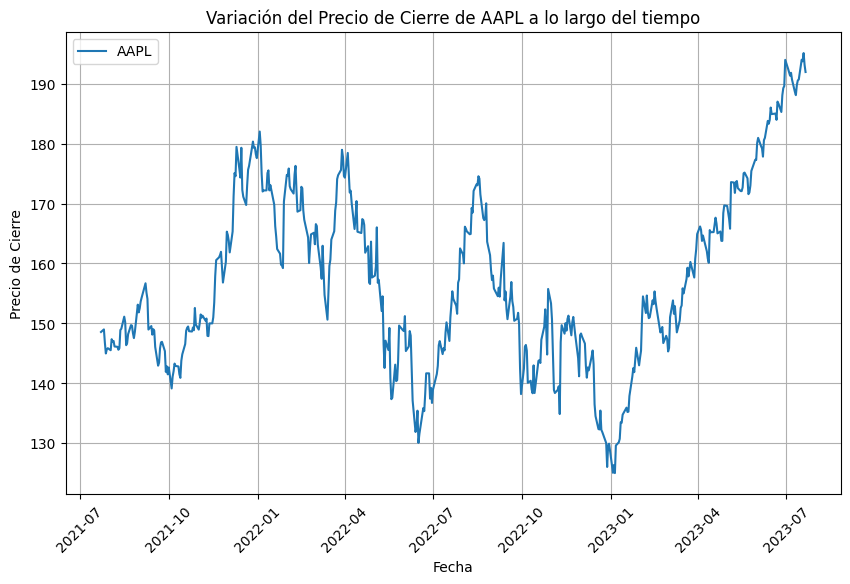

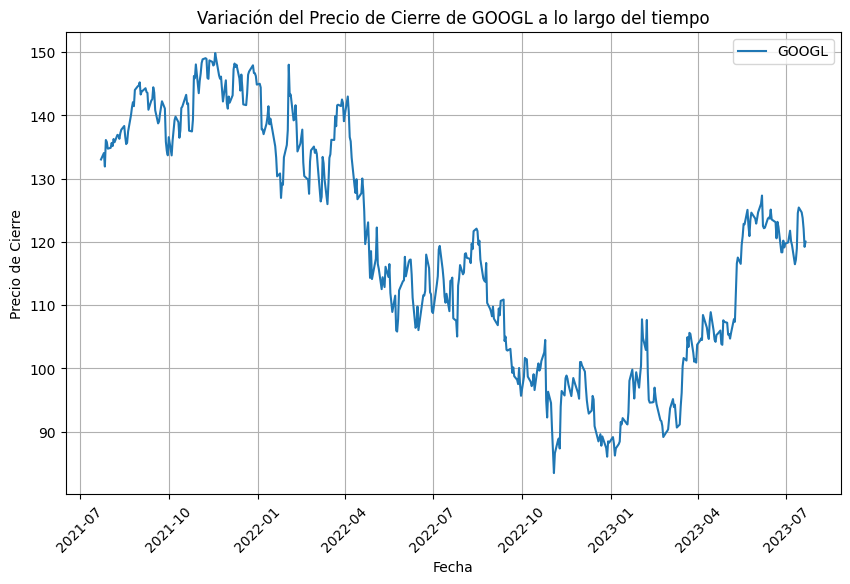

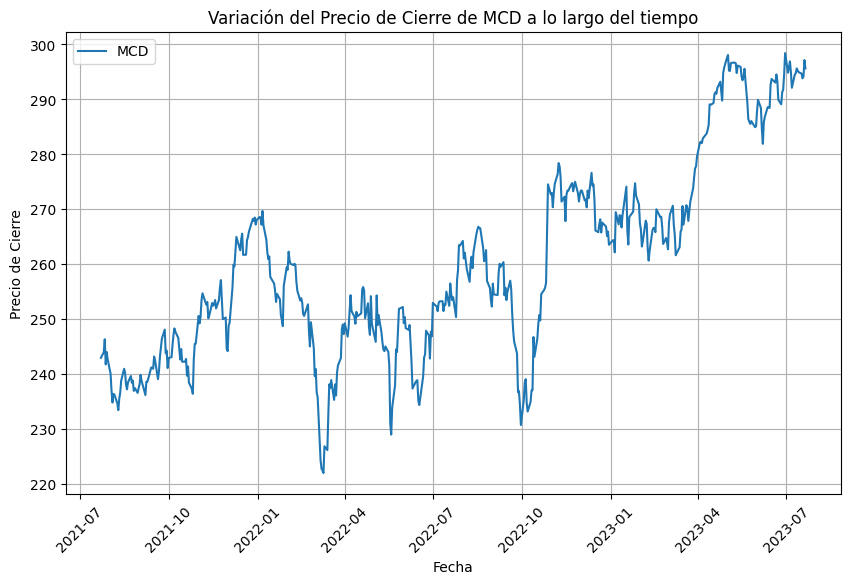

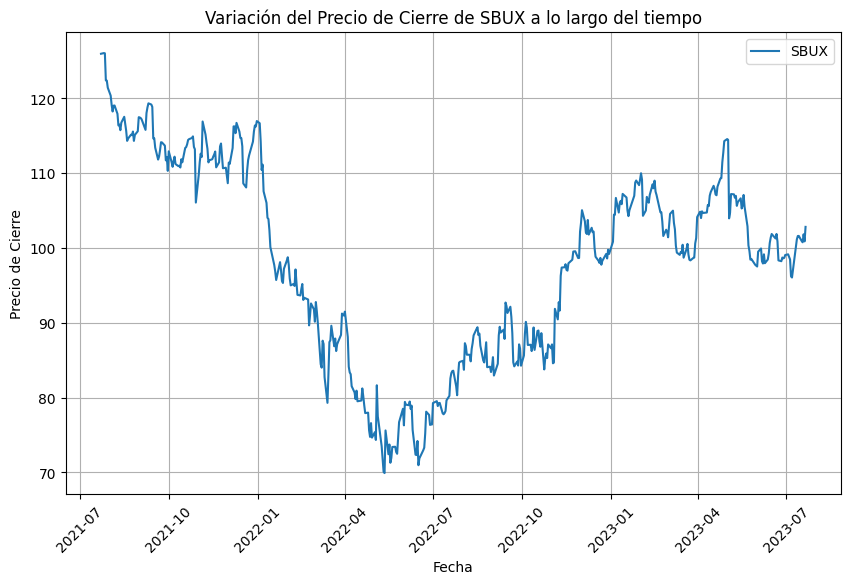

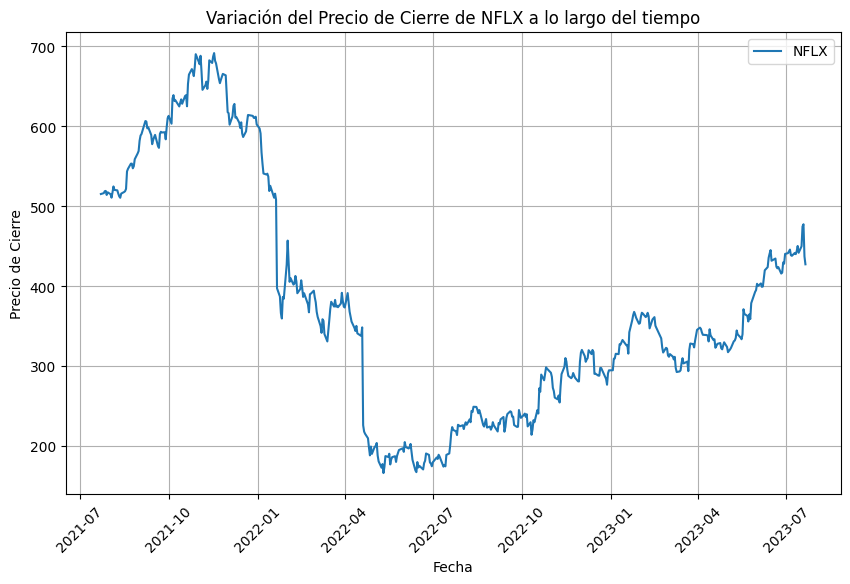

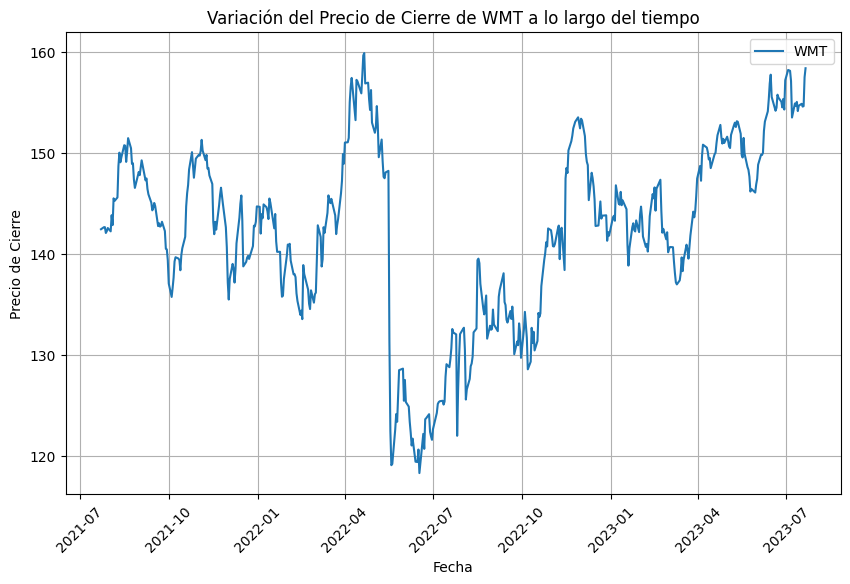

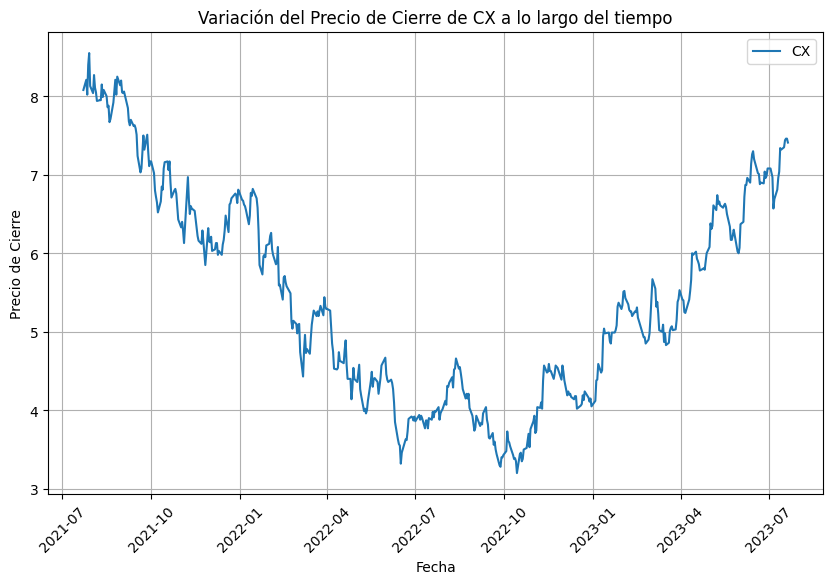

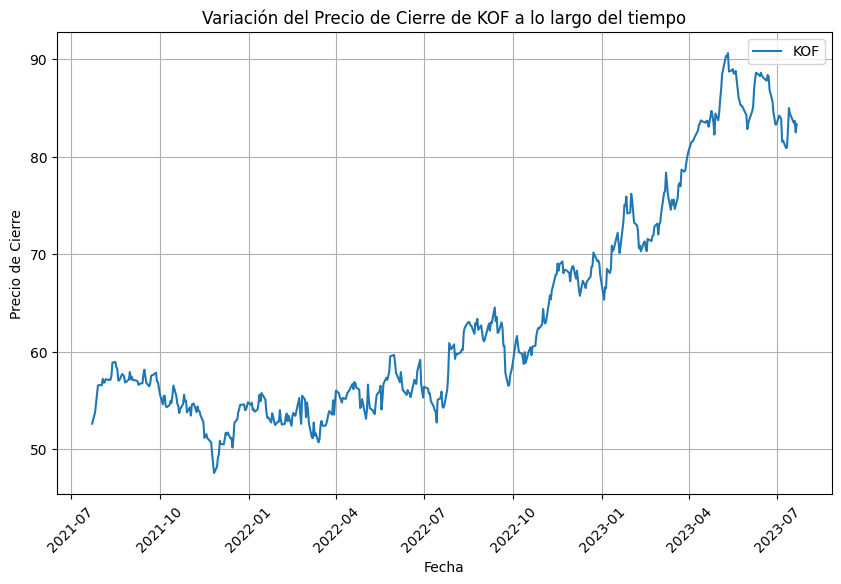

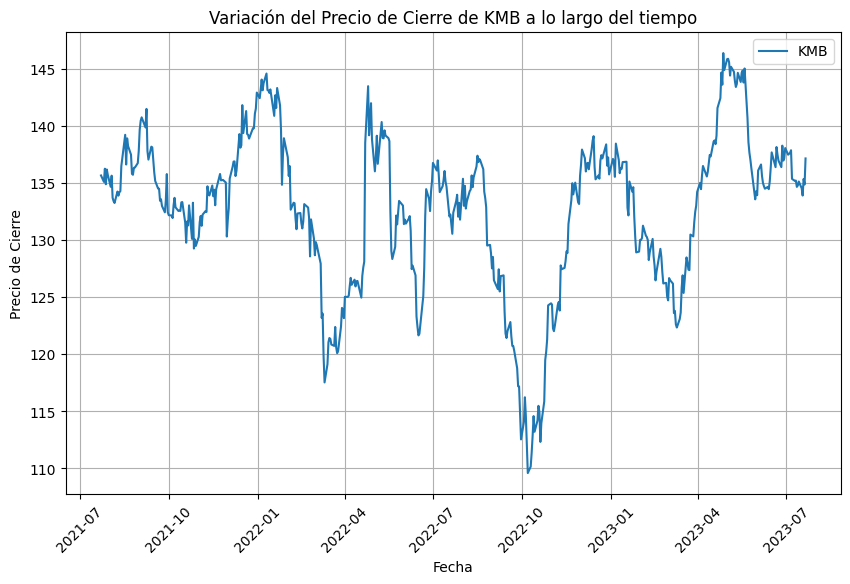

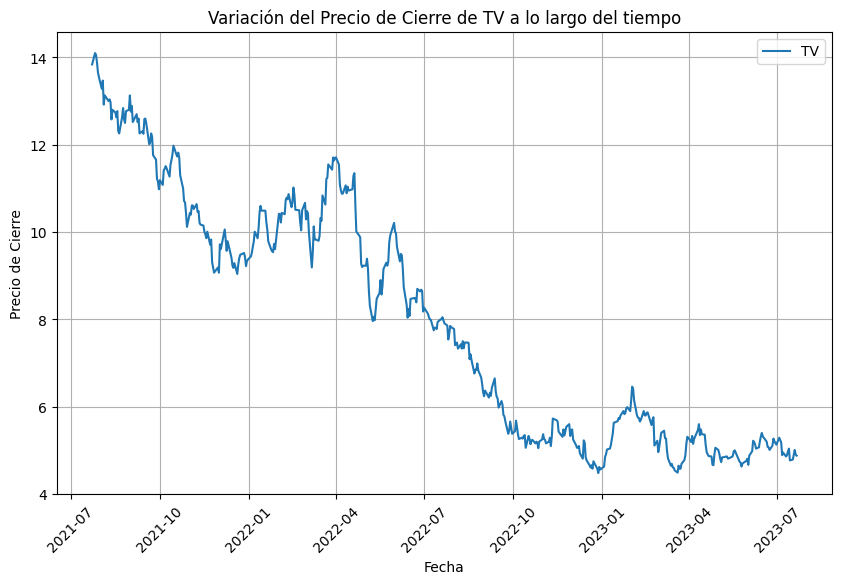

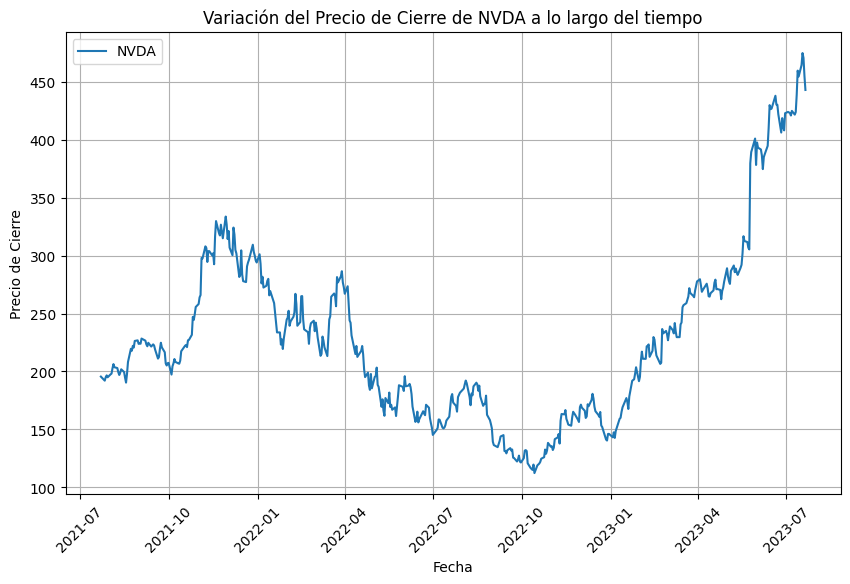

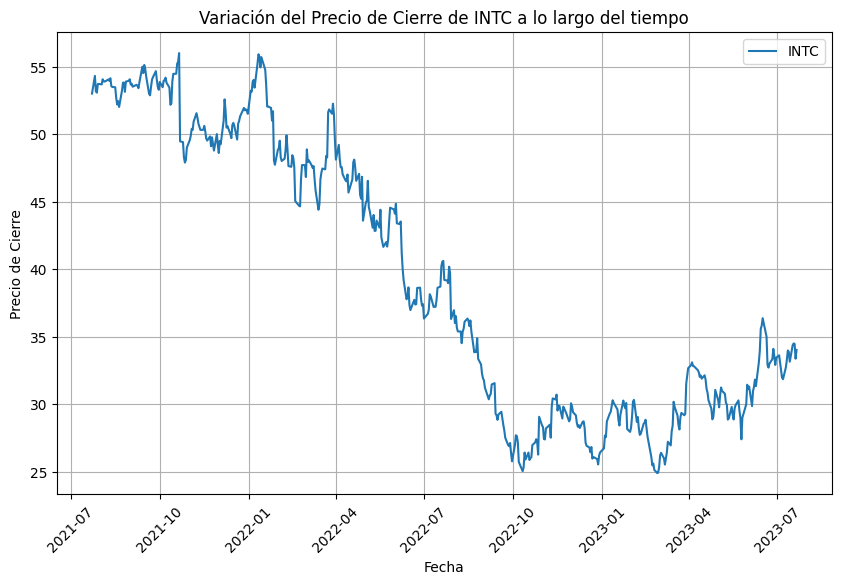

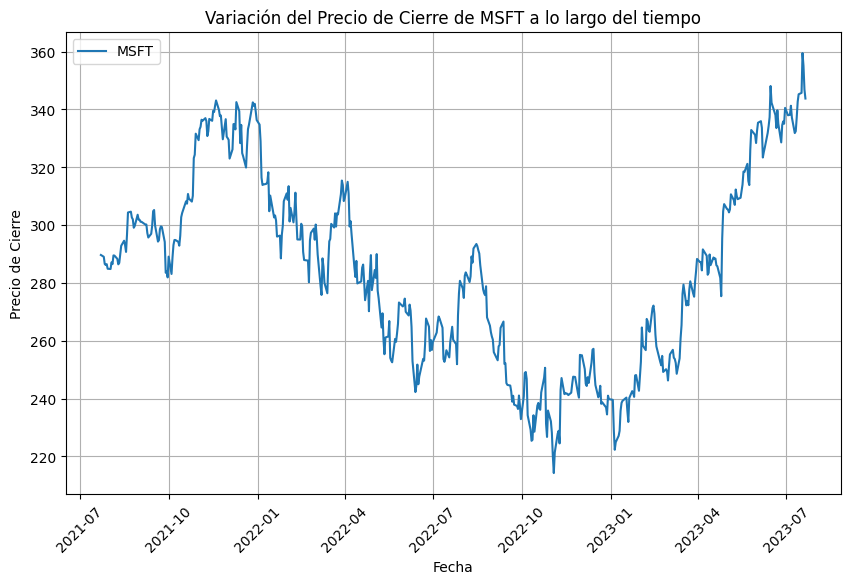

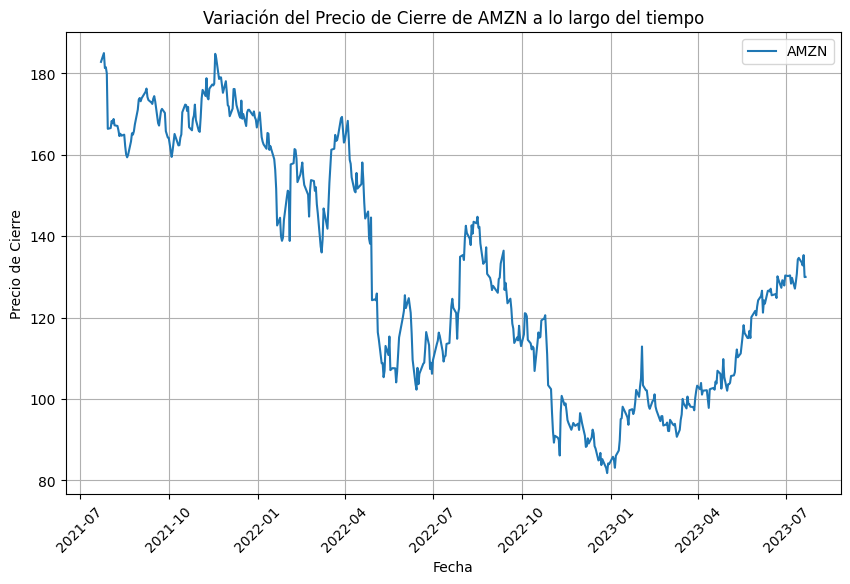

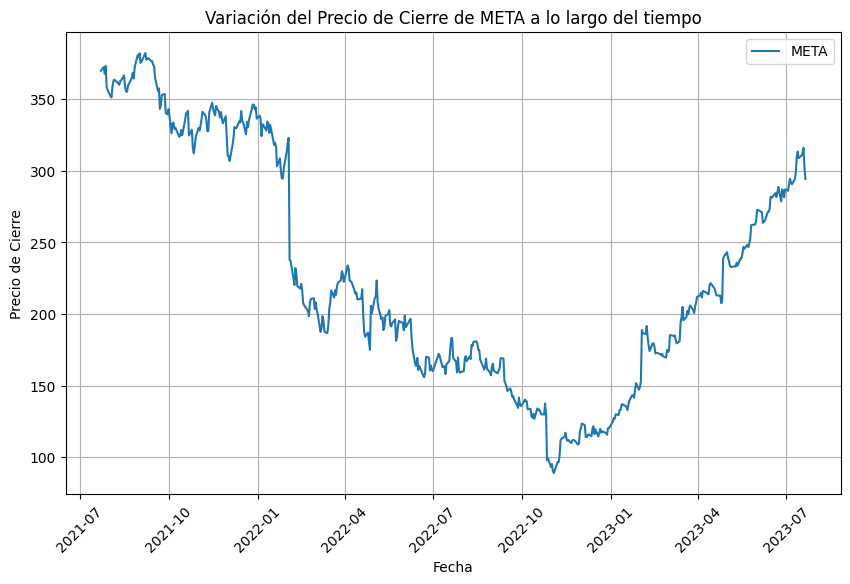

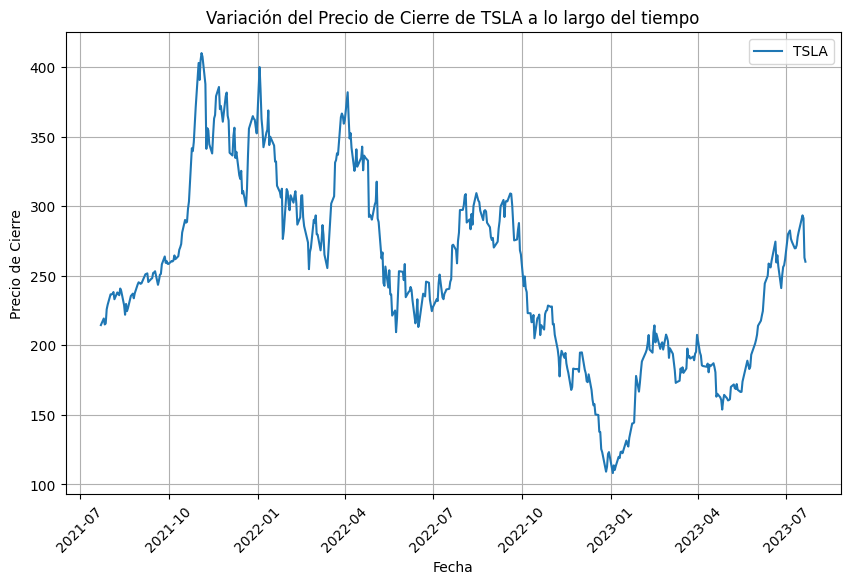

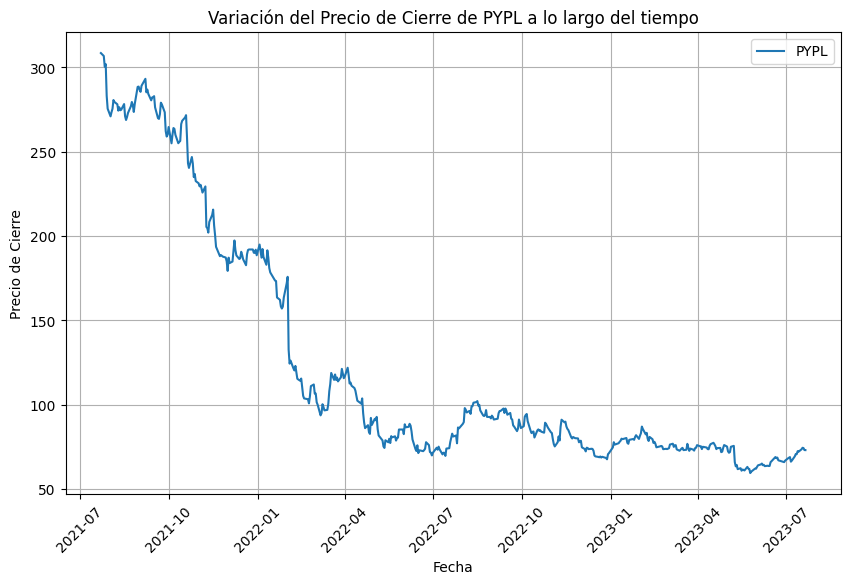

In [13]:
# Ejemplo de uso:
#empresa_a_graficar = 'AAPL'  # Puedes cambiar esto por otra empresa de la lista
for empresa in empresas:
    grafico_lineas(df, empresa)

In [14]:
#Histograma
def grafico_velas(df, empresa):
    df_empresa = df[df['Symbol'] == empresa]
    plt.figure(figsize=(12, 6))
    plt.plot(df_empresa['Date'], df_empresa['High'], color='green', label='Máximo')
    plt.plot(df_empresa['Date'], df_empresa['Low'], color='red', label='Mínimo')
    plt.vlines(df_empresa['Date'], df_empresa['Open'], df_empresa['Close'], color='black', linewidth=4)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.title(f'Gráfico de Velas de {empresa}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

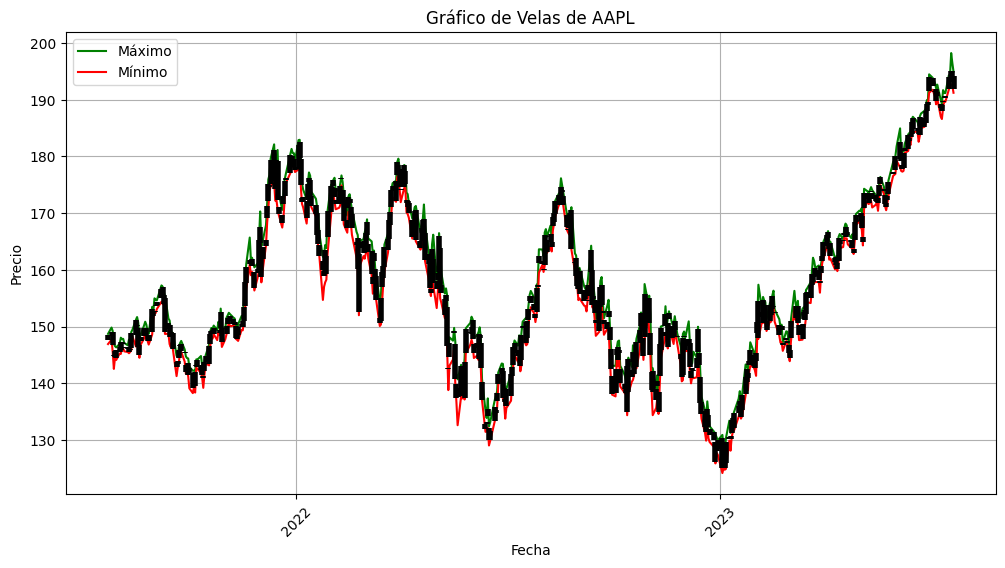

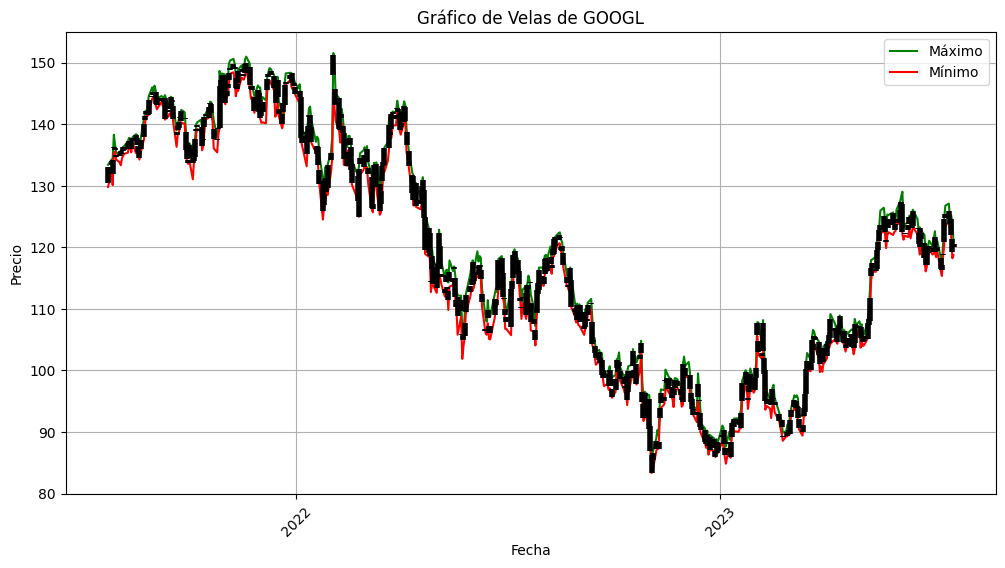

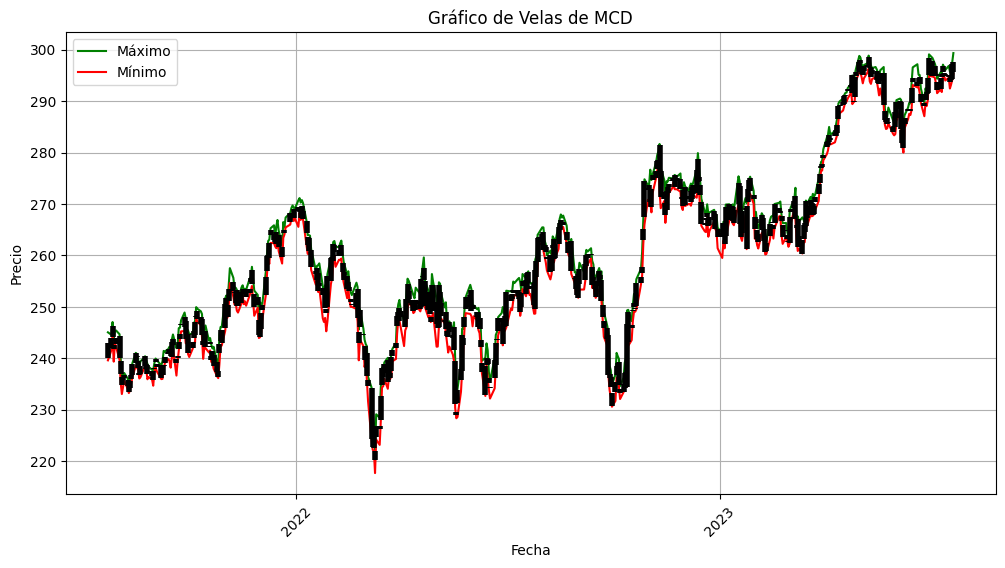

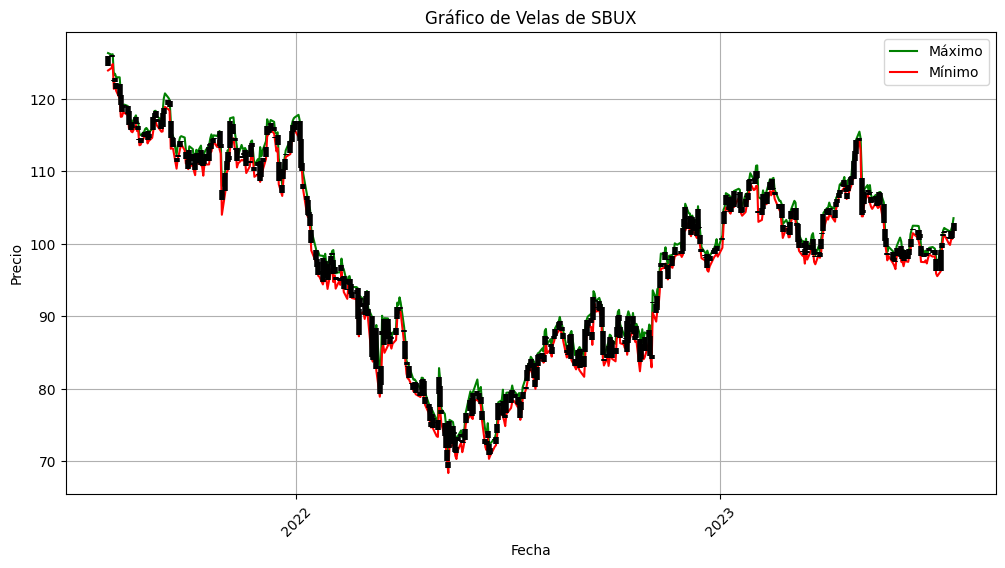

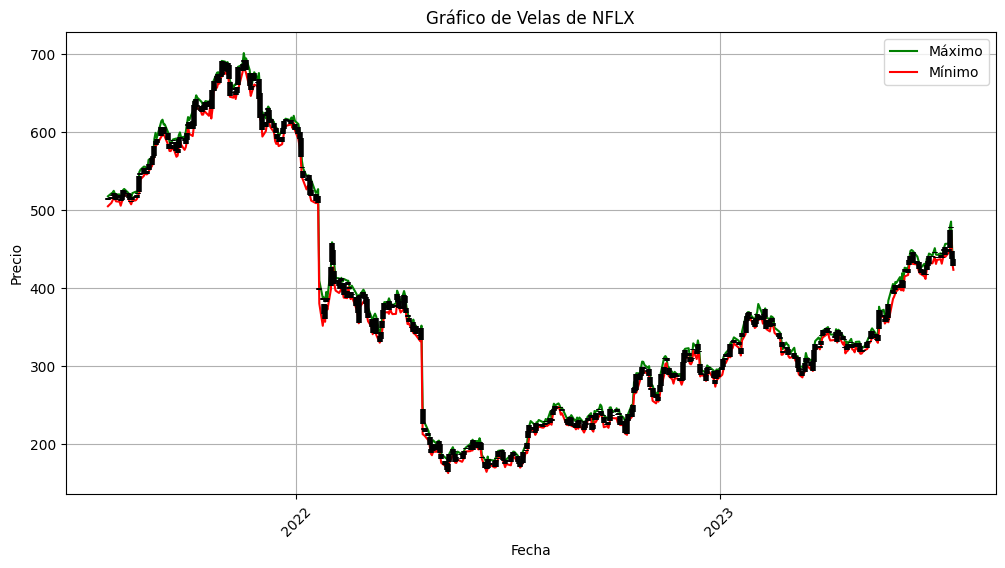

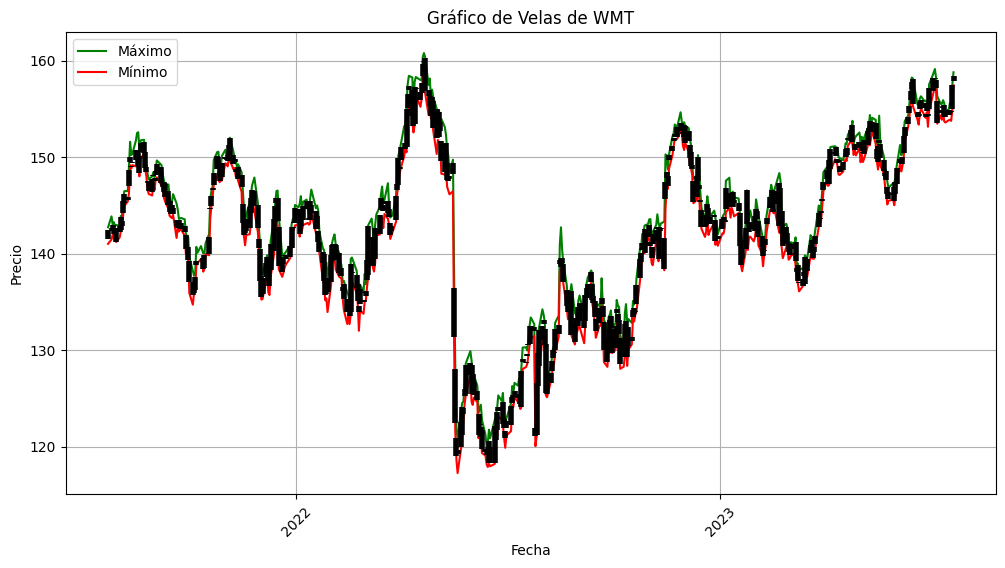

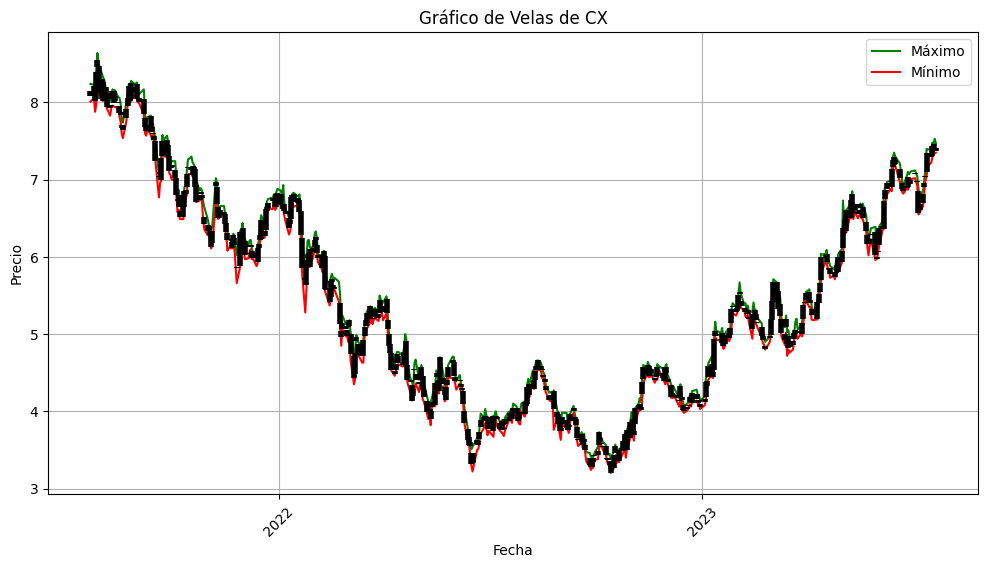

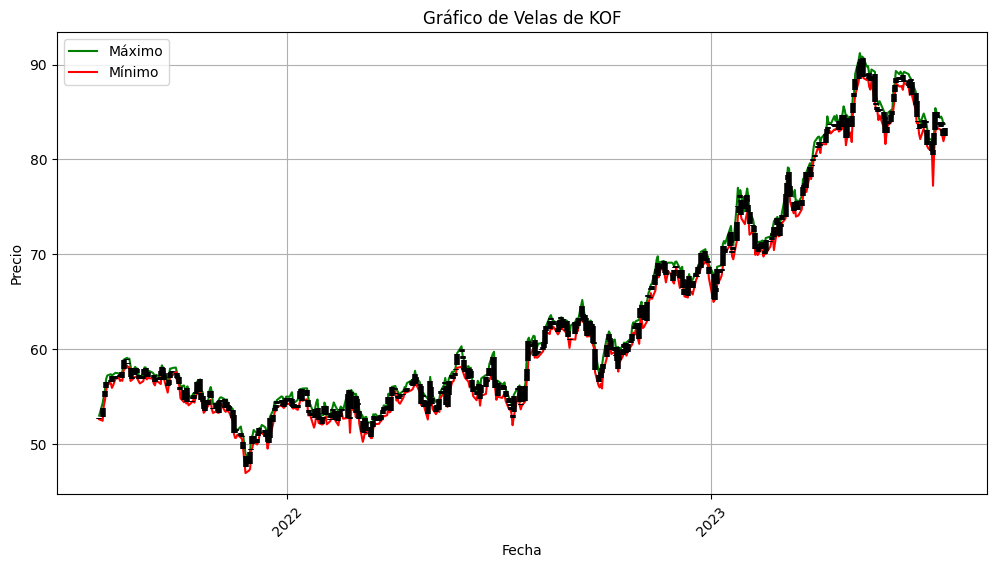

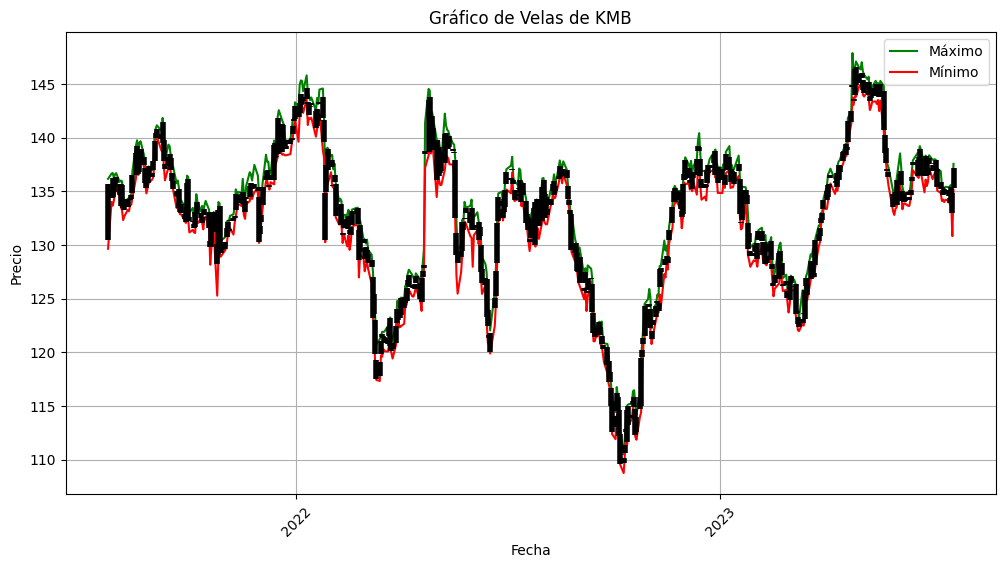

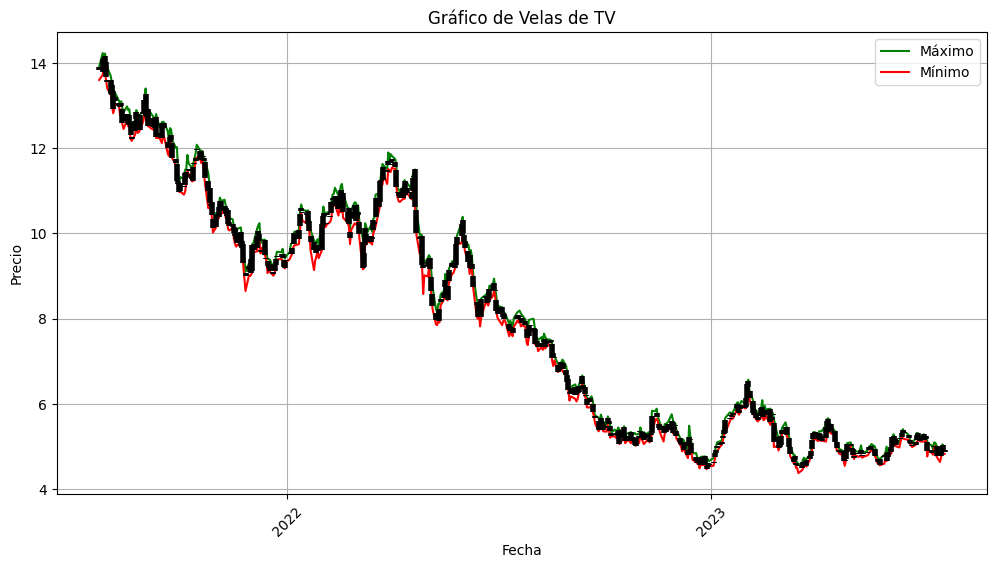

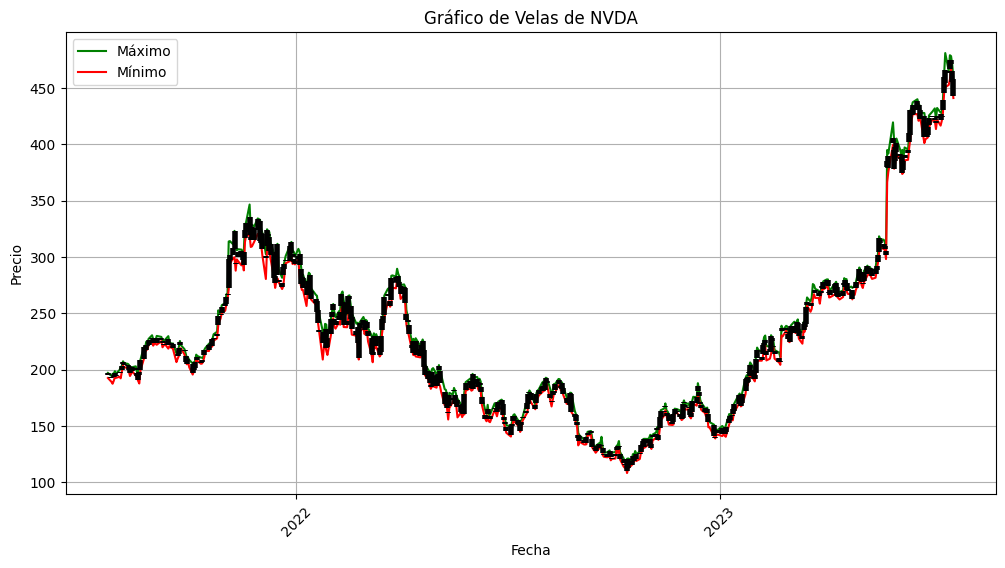

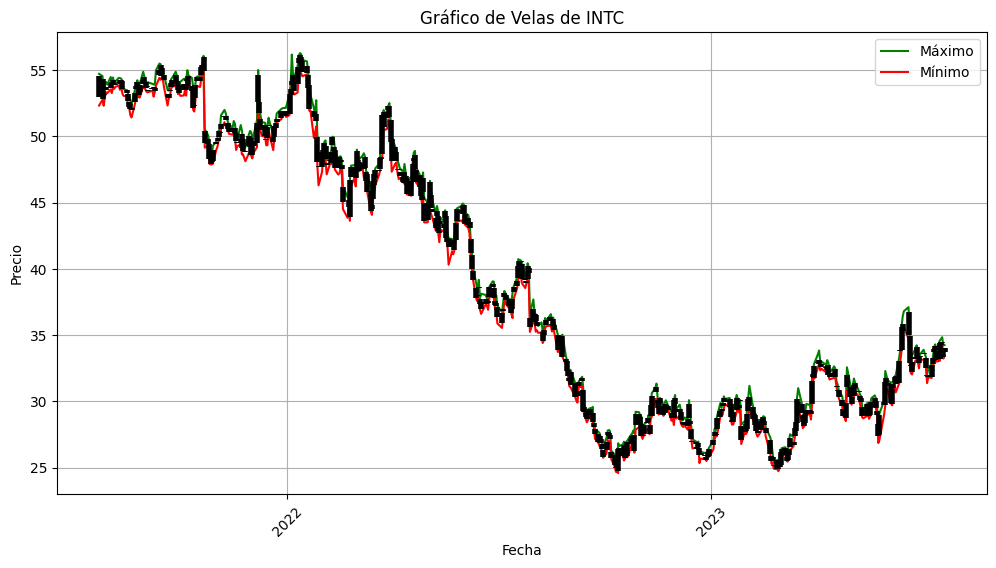

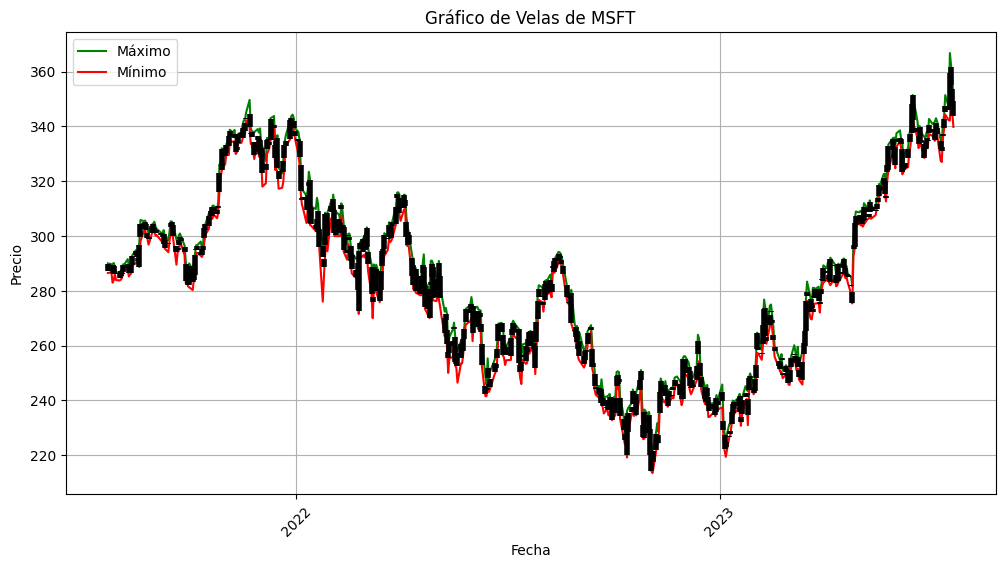

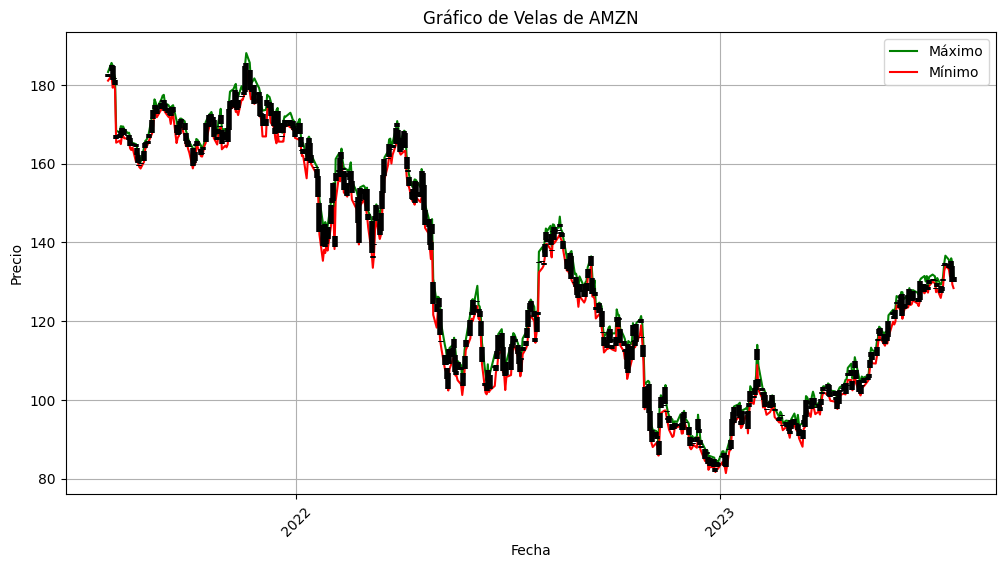

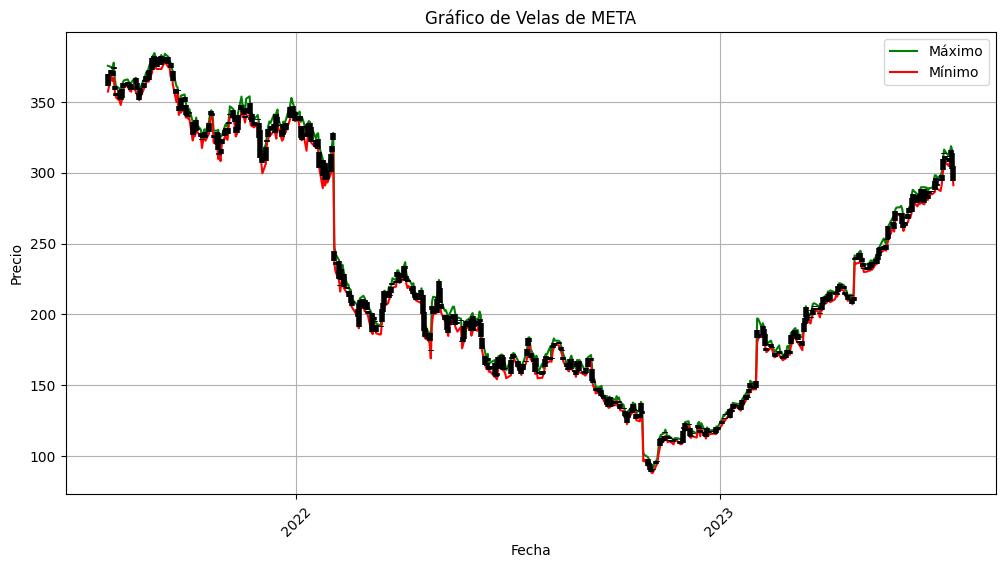

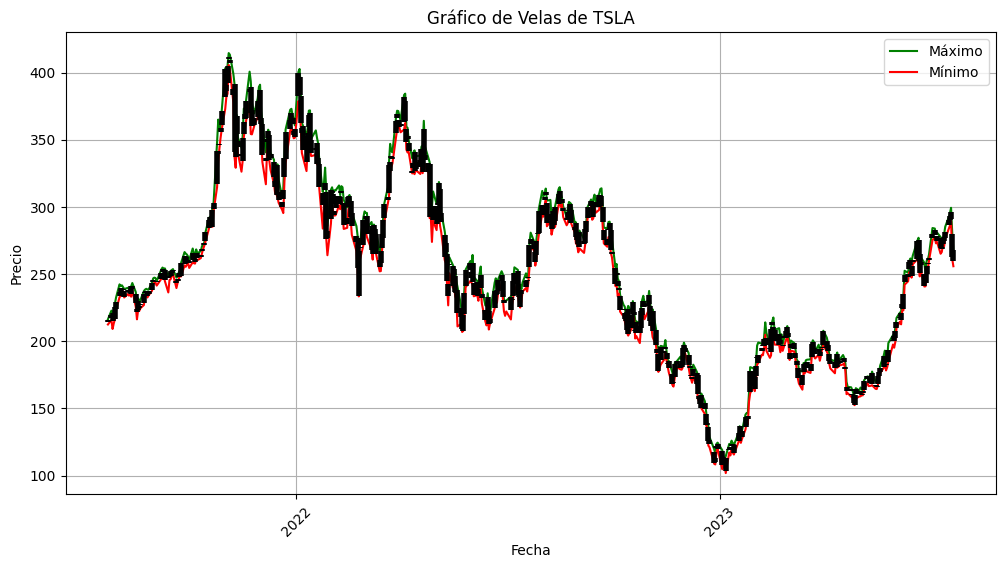

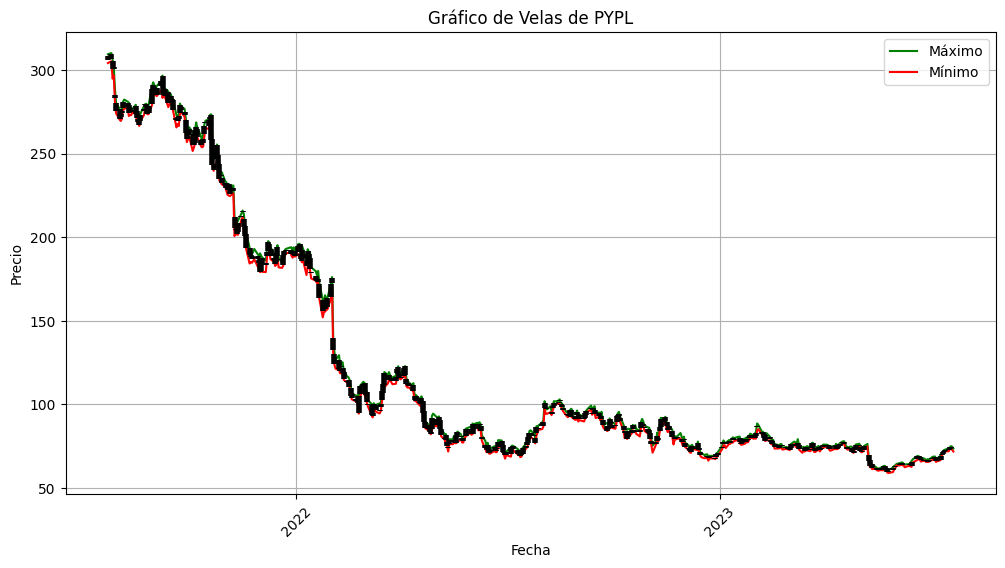

In [15]:

# Ejemplo de uso:
#empresa_a_graficar = 'AAPL'  # Puedes cambiar esto por otra empresa de la lista
for empresa in empresas:
    grafico_velas(df, empresa)

In [16]:
def histograma_precios_cierre(df, empresa):
    plt.figure(figsize=(10, 6))
    df_empresa = df[df['Symbol'] == empresa]
    sns.histplot(df_empresa['Close'], kde=True)
    plt.xlabel('Precio de Cierre')
    plt.ylabel('Frecuencia')
    plt.title(f'Histograma de Precios de Cierre de {empresa}')
    plt.grid(True)
    plt.show()
    

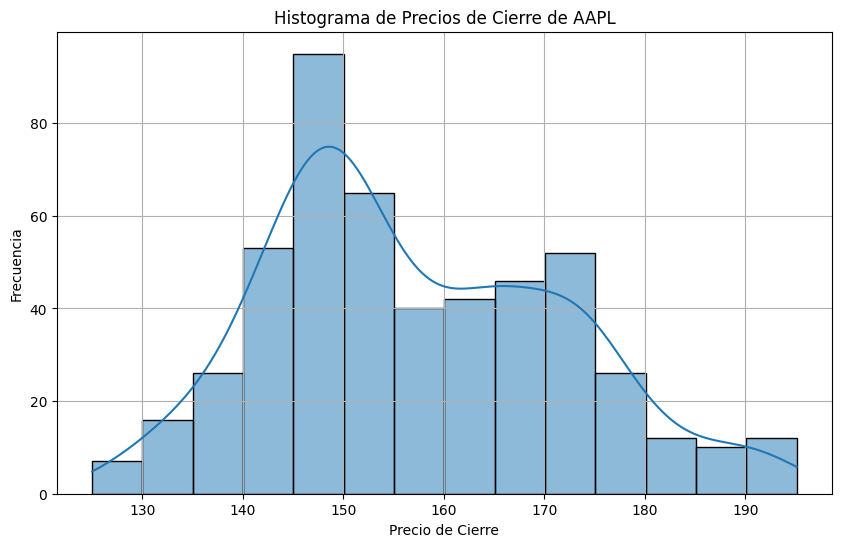

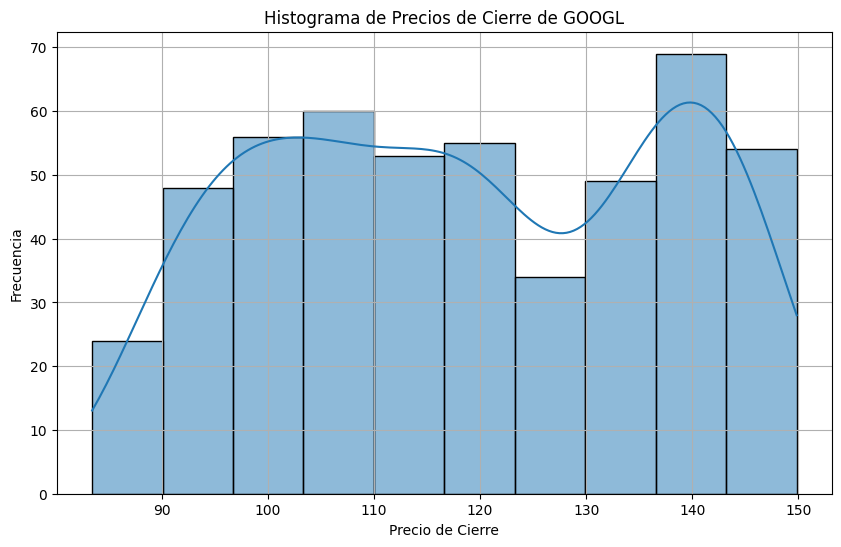

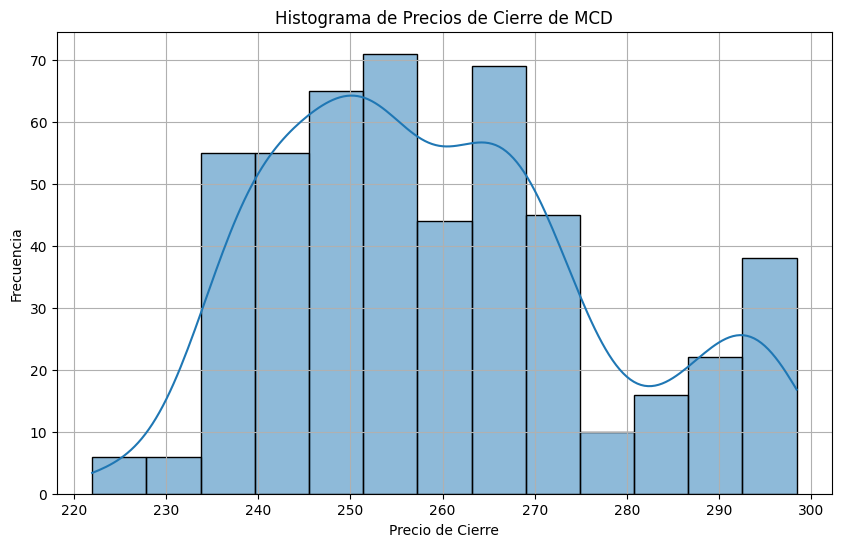

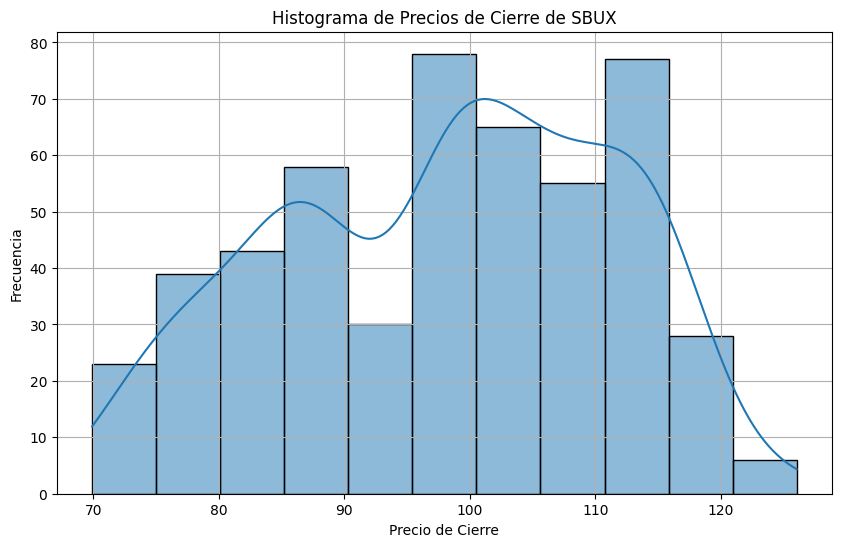

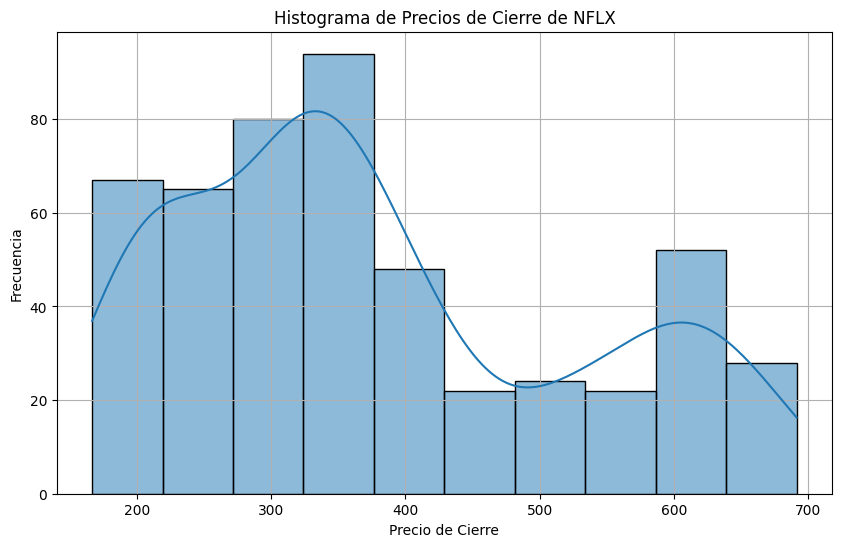

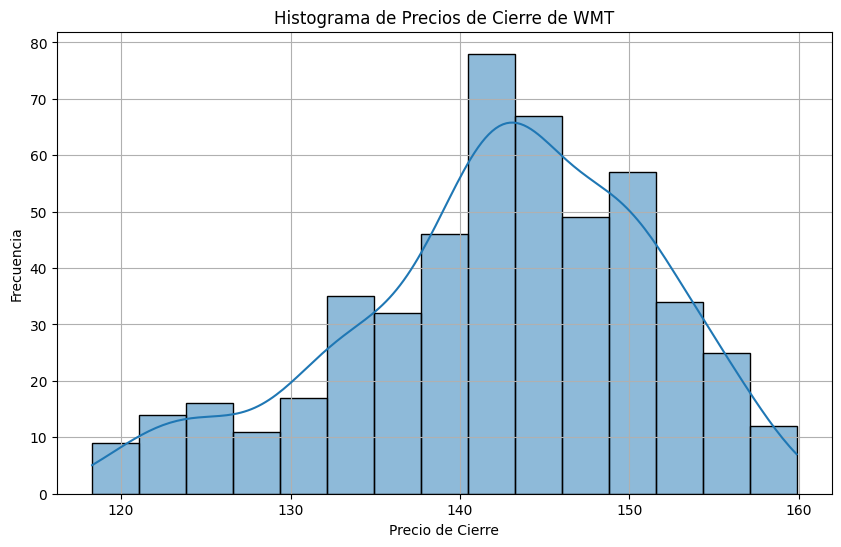

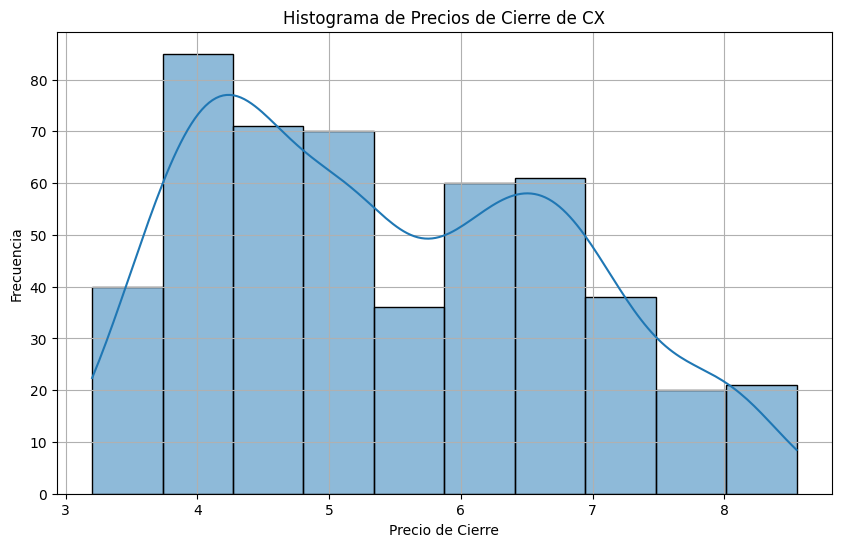

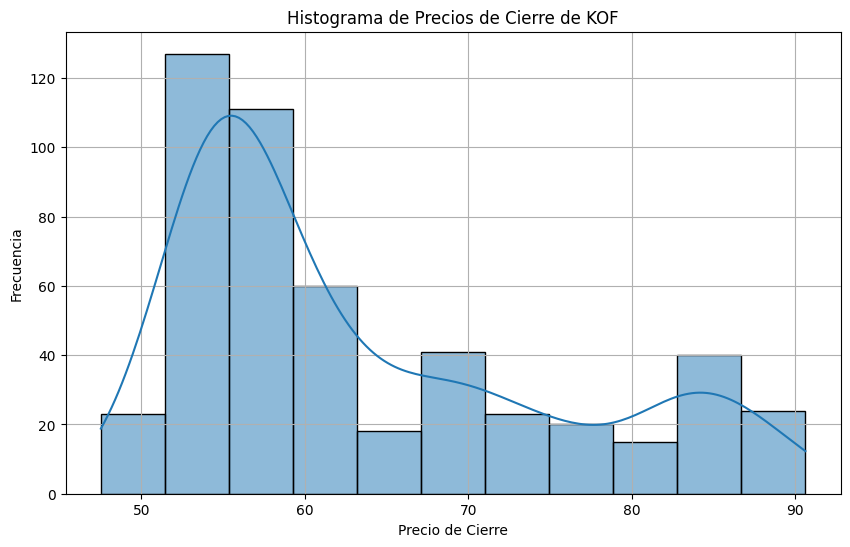

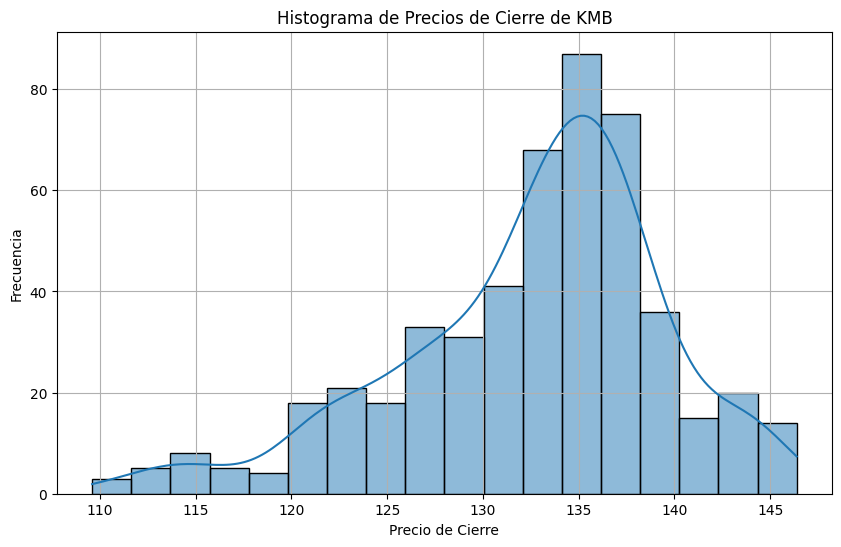

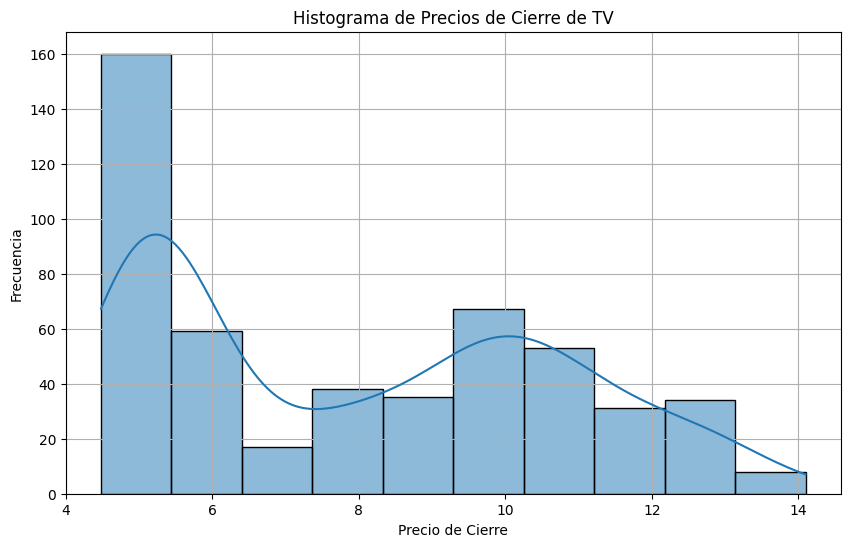

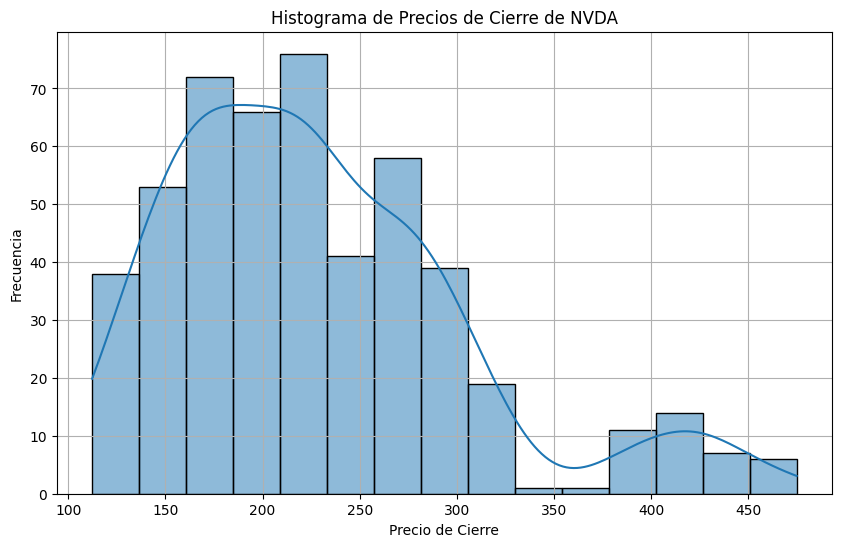

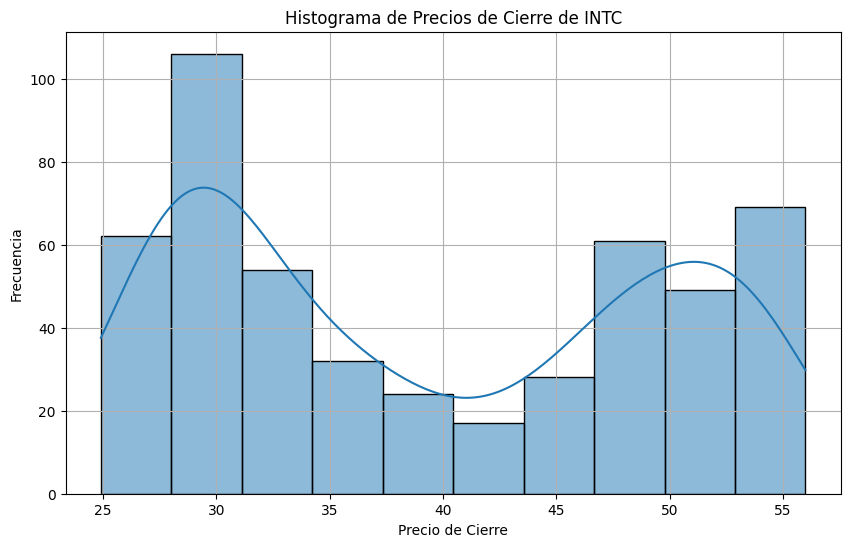

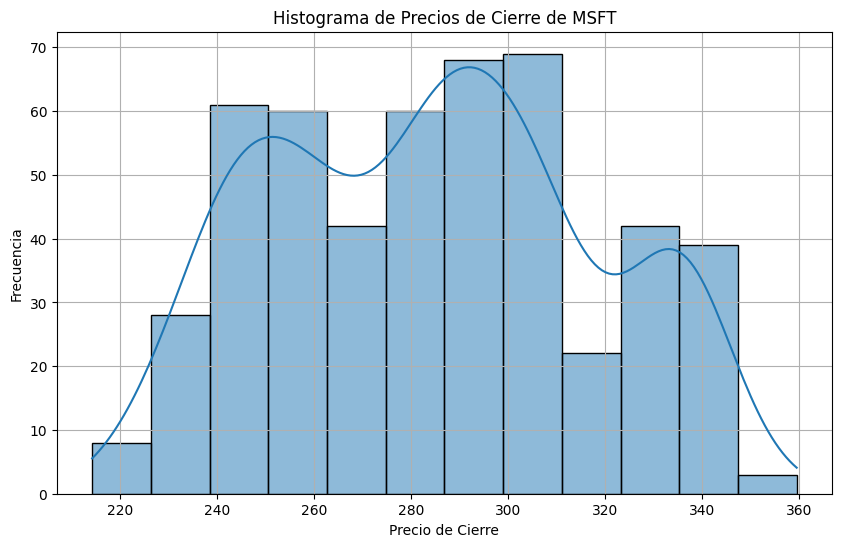

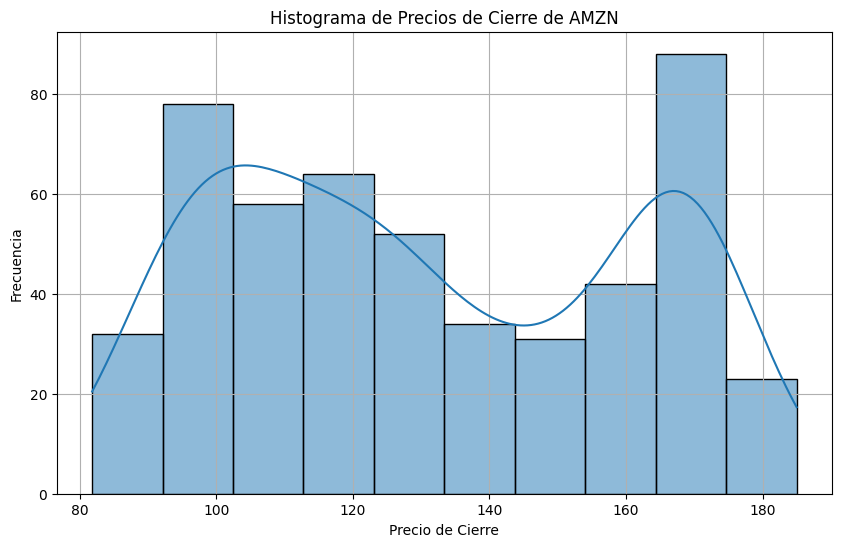

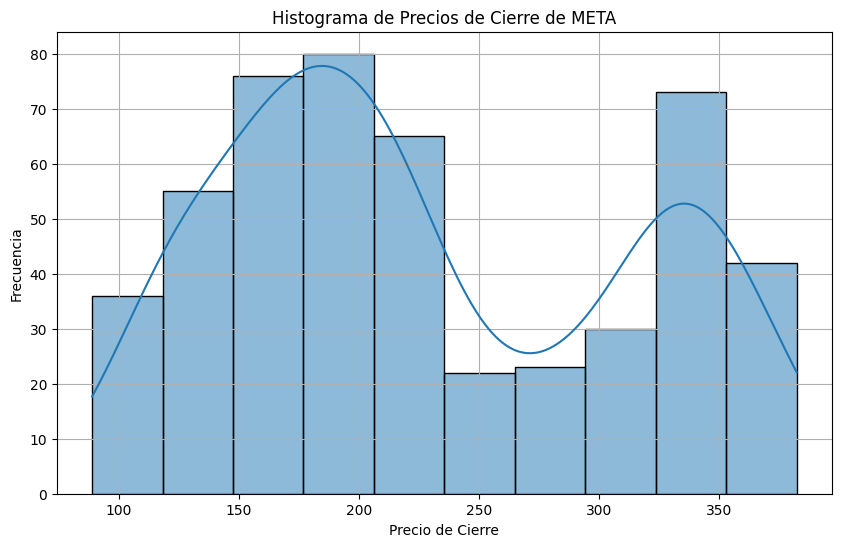

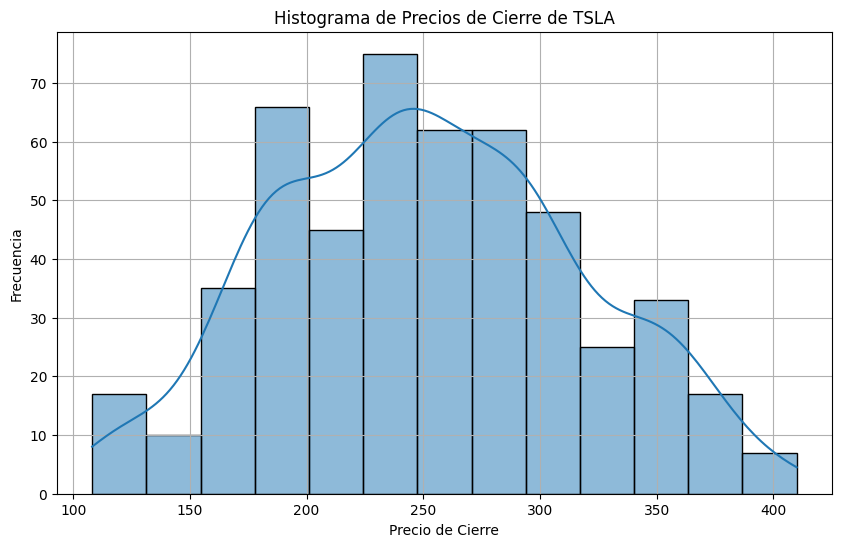

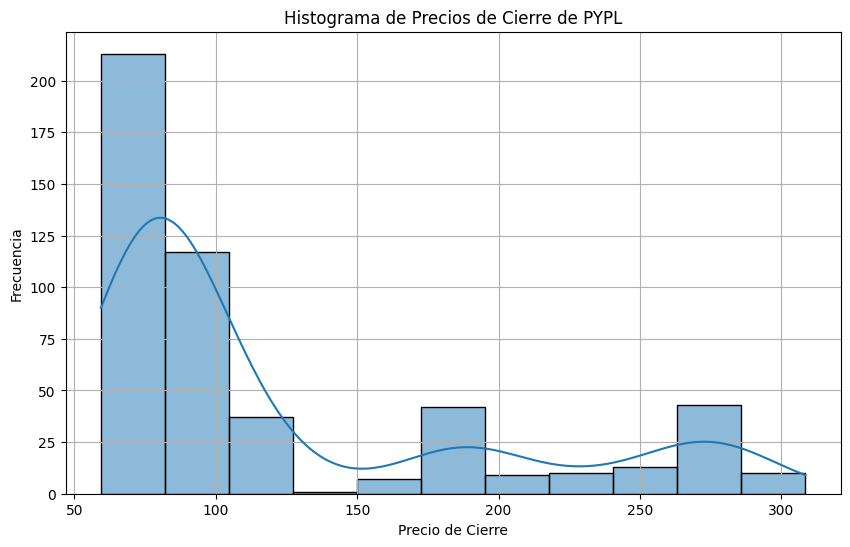

In [17]:
# Ejemplo de uso:
#empresa_a_graficar = 'AAPL'  # Puedes cambiar est*o por otra empresa de la lista
for empresa in empresas:
    histograma_precios_cierre(df, empresa)

In [18]:
def grafico_barras_volumen(df, fecha):
    plt.figure(figsize=(10, 6))
    df_fecha = df[df['Date'] == fecha]
    plt.bar(df_fecha['Symbol'], df_fecha['Volume'])
    plt.xlabel('Empresa')
    plt.ylabel('Volumen de Acciones Negociadas')
    plt.title(f'Volumen de Acciones Negociadas el {fecha}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

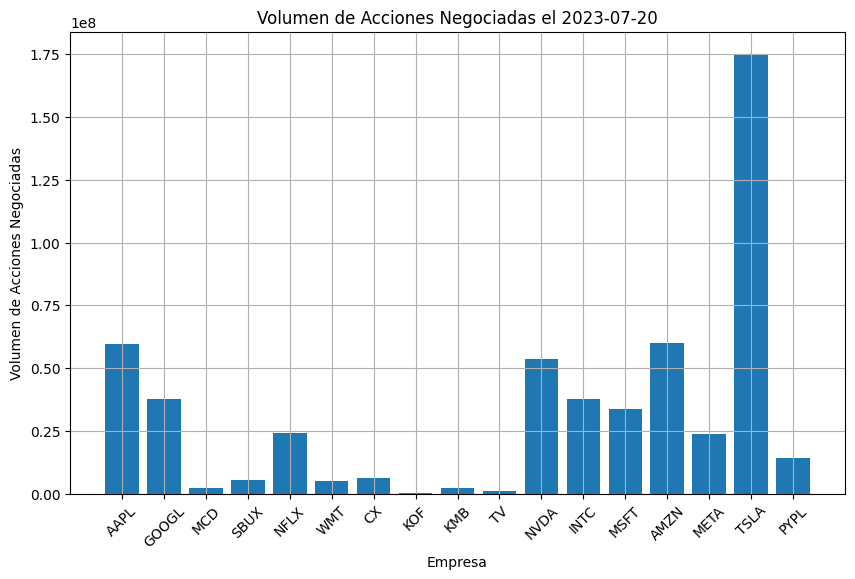

In [19]:
# Ejemplo de uso:
fecha_a_graficar = '2023-07-20'  # Puedes cambiar esto por otra fecha presente en tus datos
grafico_barras_volumen(df, fecha_a_graficar)

In [20]:
def grafico_area_volumen(df, empresa):
    plt.figure(figsize=(12, 6))
    df_empresa = df[df['Symbol'] == empresa]
    plt.fill_between(df_empresa['Date'], df_empresa['Volume'], color='blue', alpha=0.3)
    plt.xlabel('Fecha')
    plt.ylabel('Volumen de Acciones Negociadas')
    plt.title(f'Gráfico de Área del Volumen de Acciones Negociadas para {empresa}')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

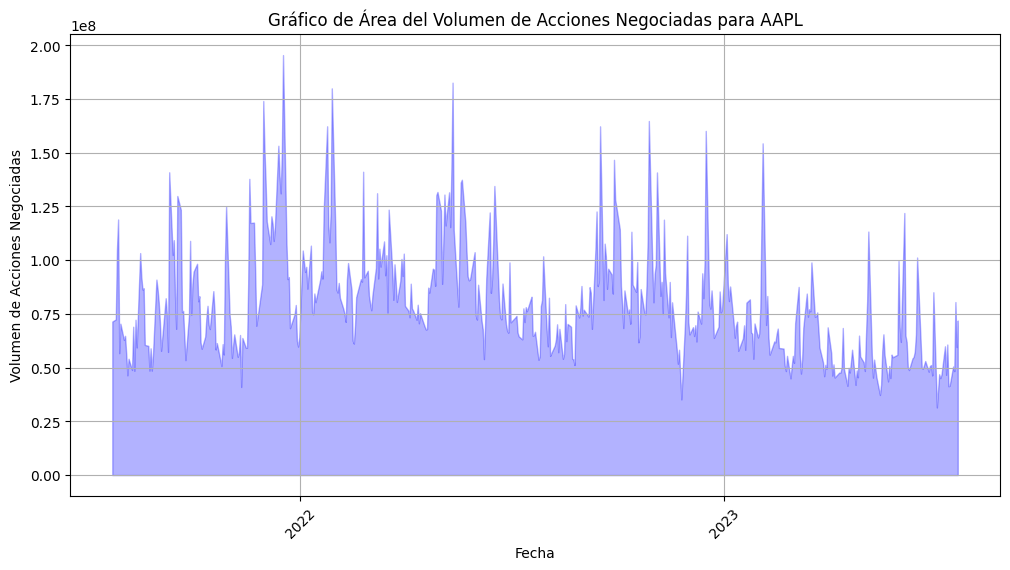

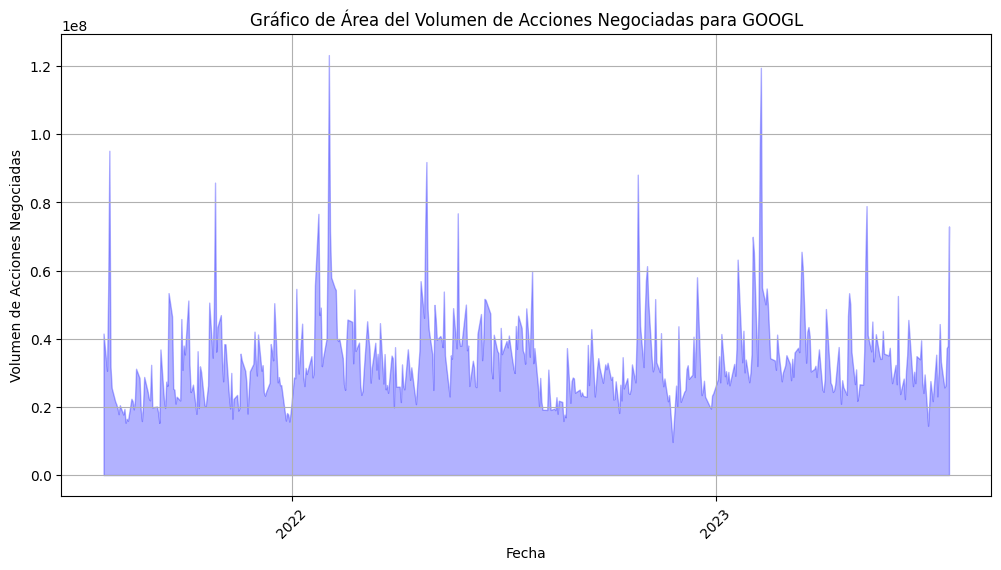

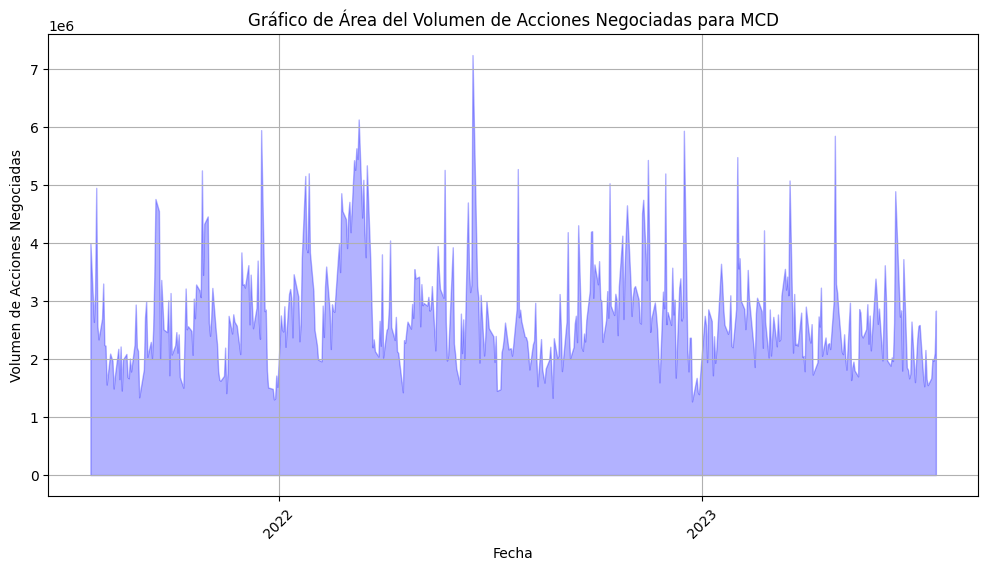

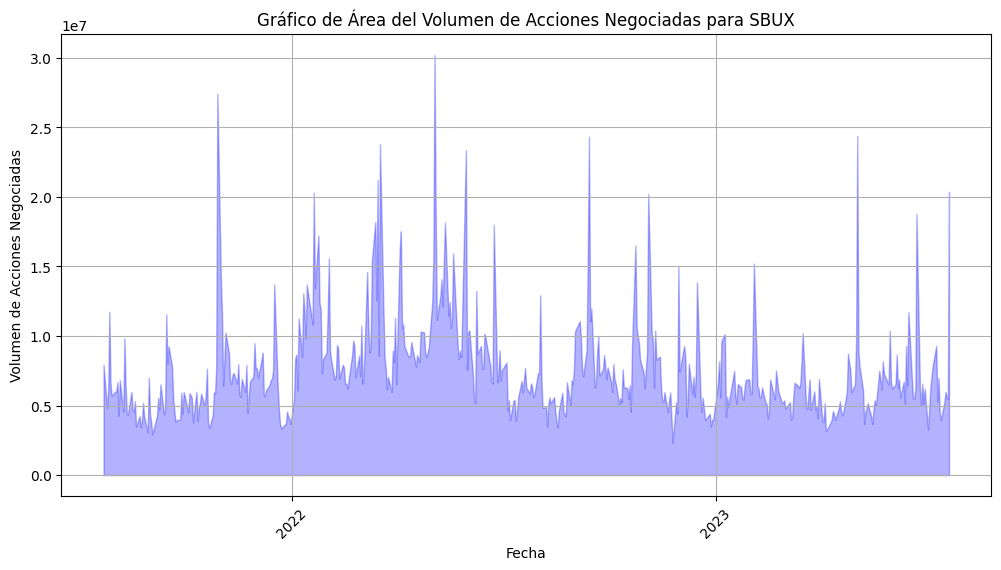

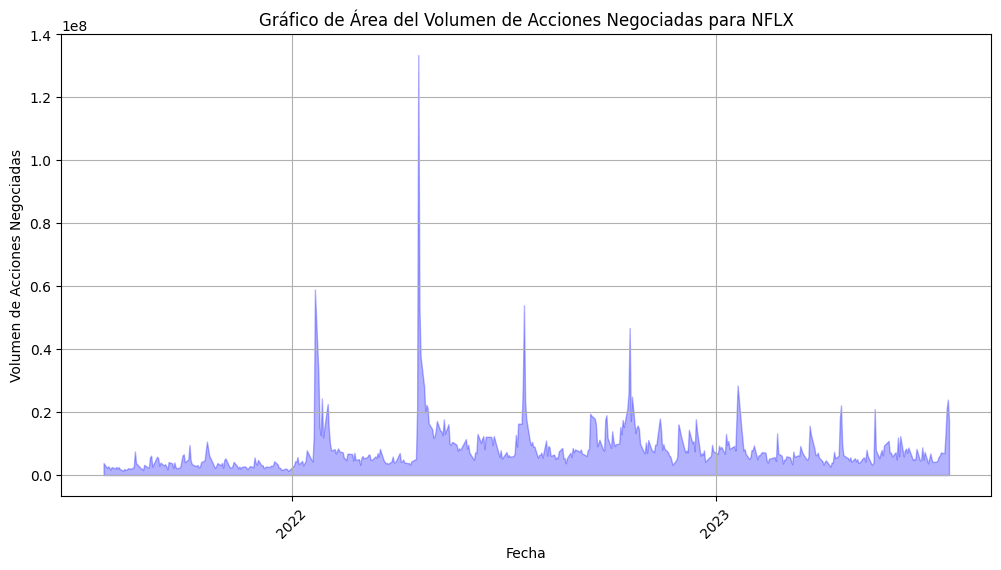

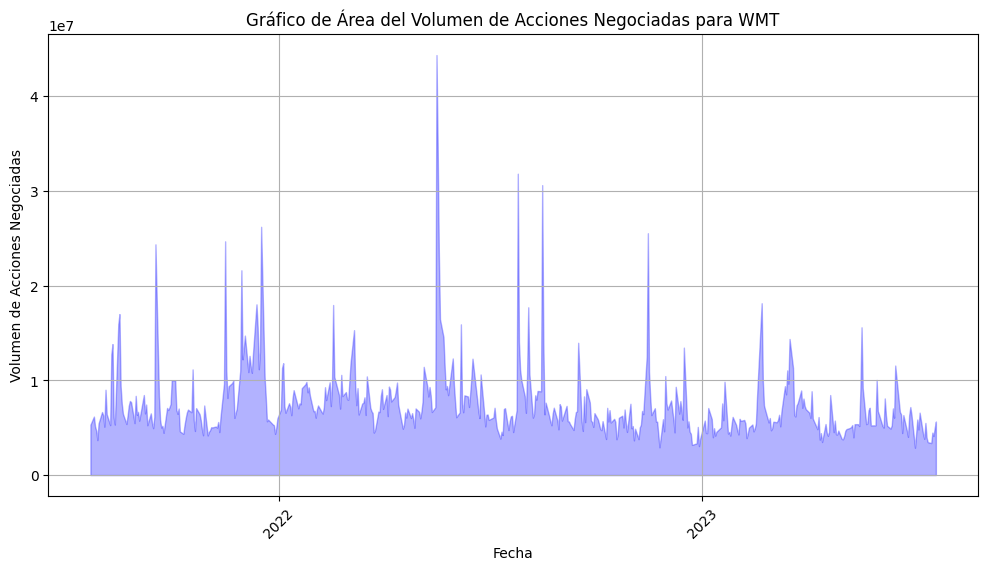

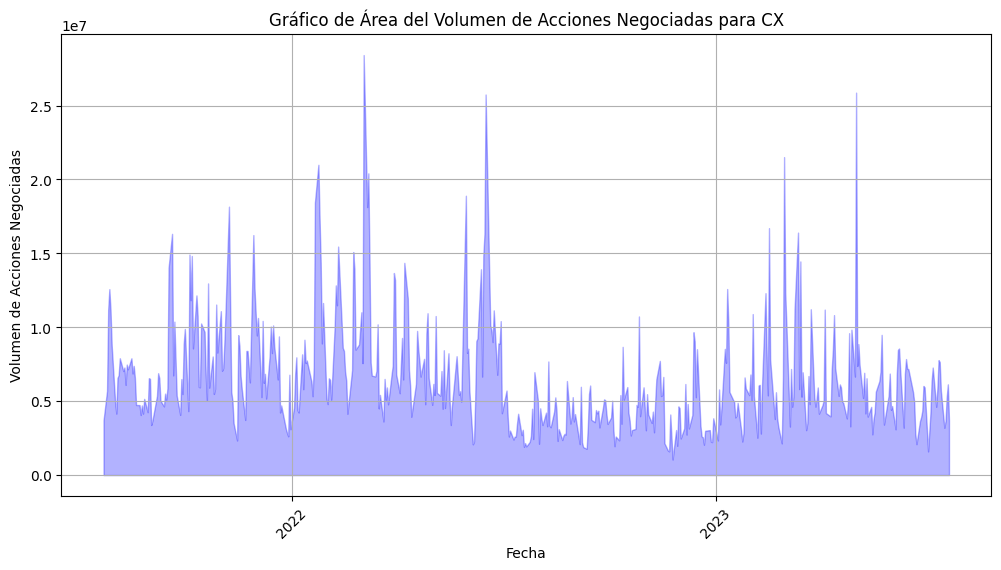

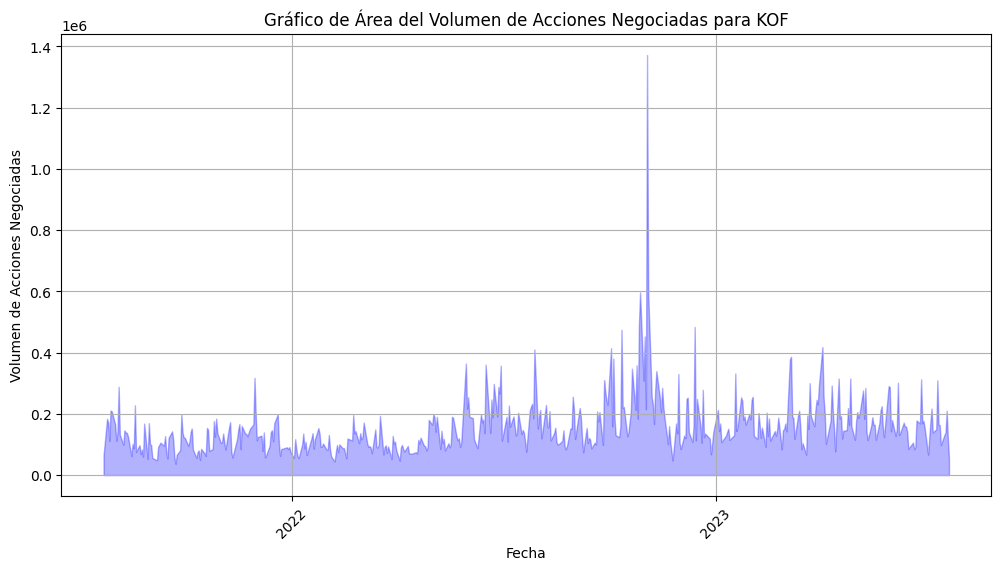

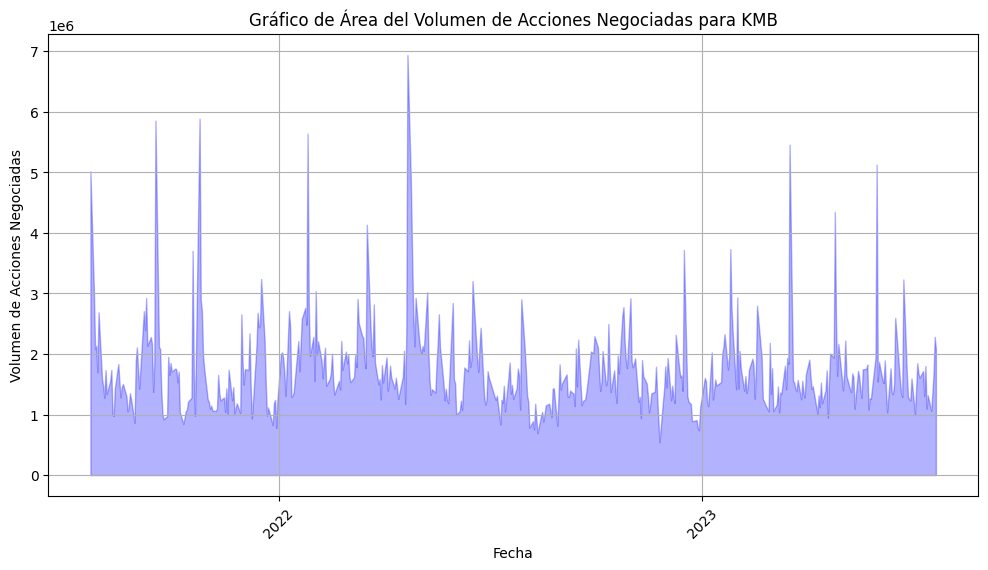

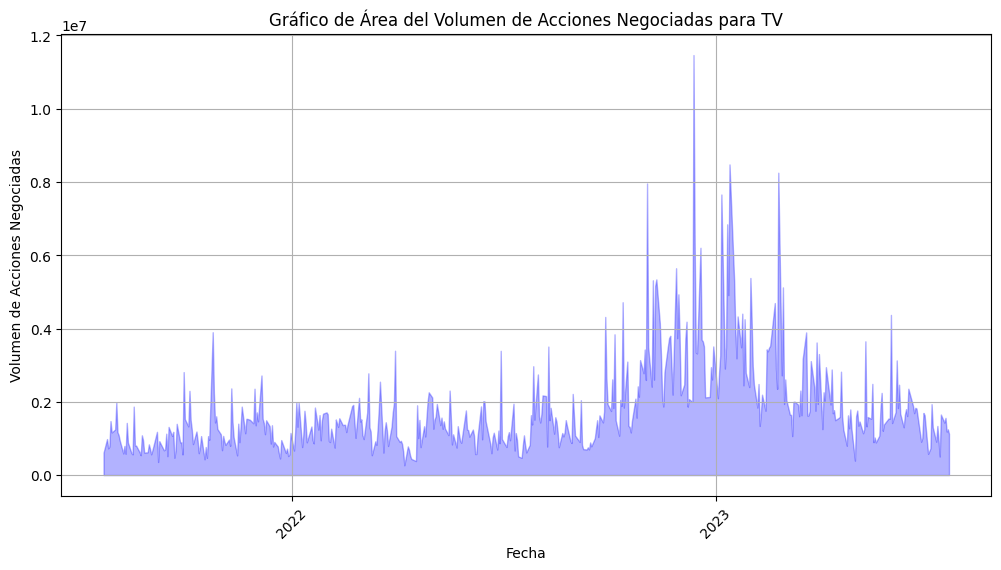

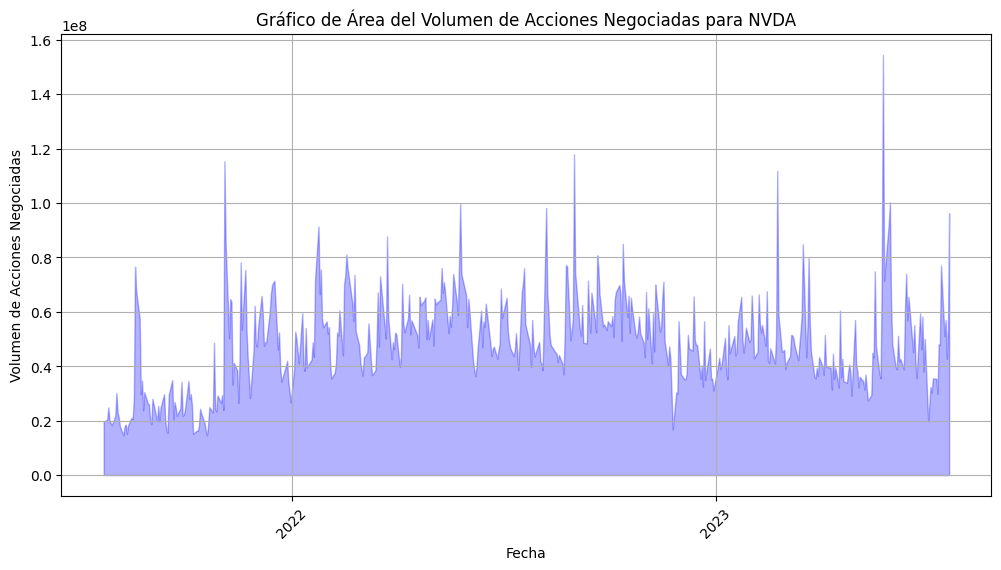

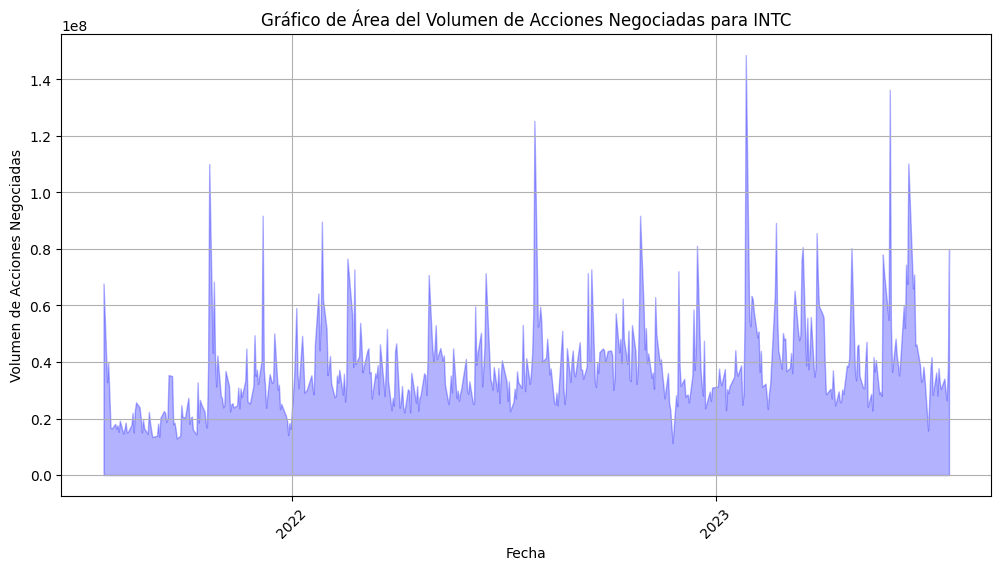

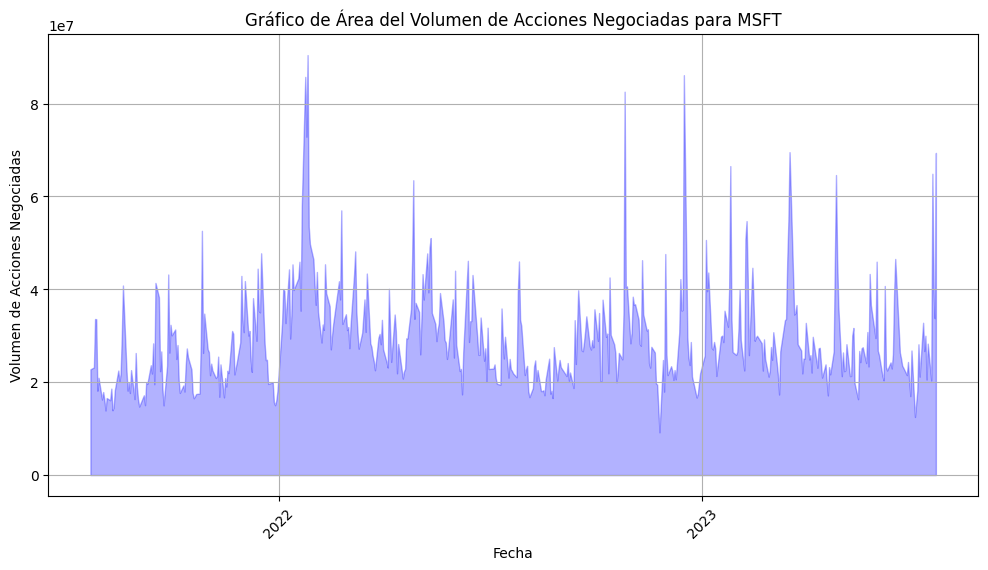

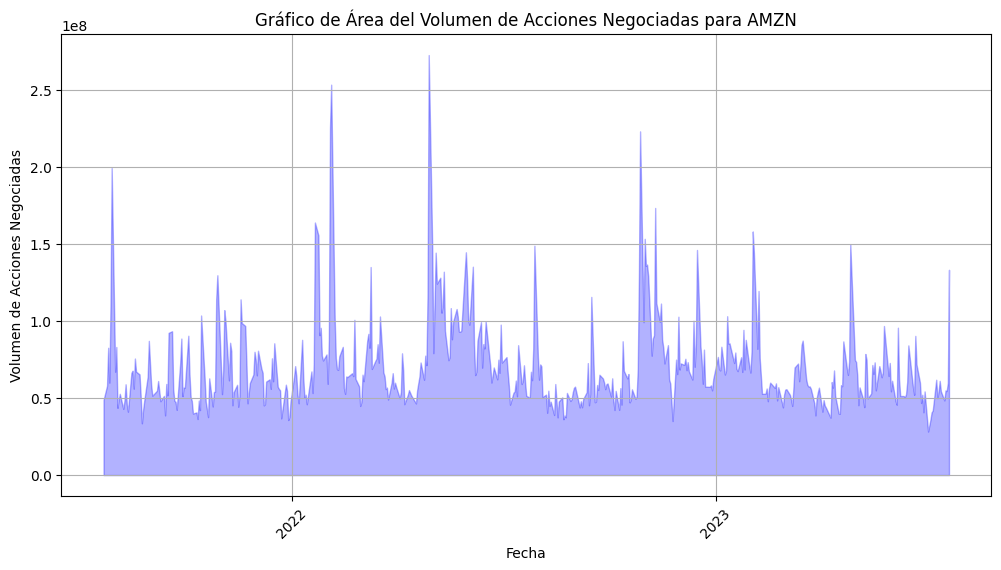

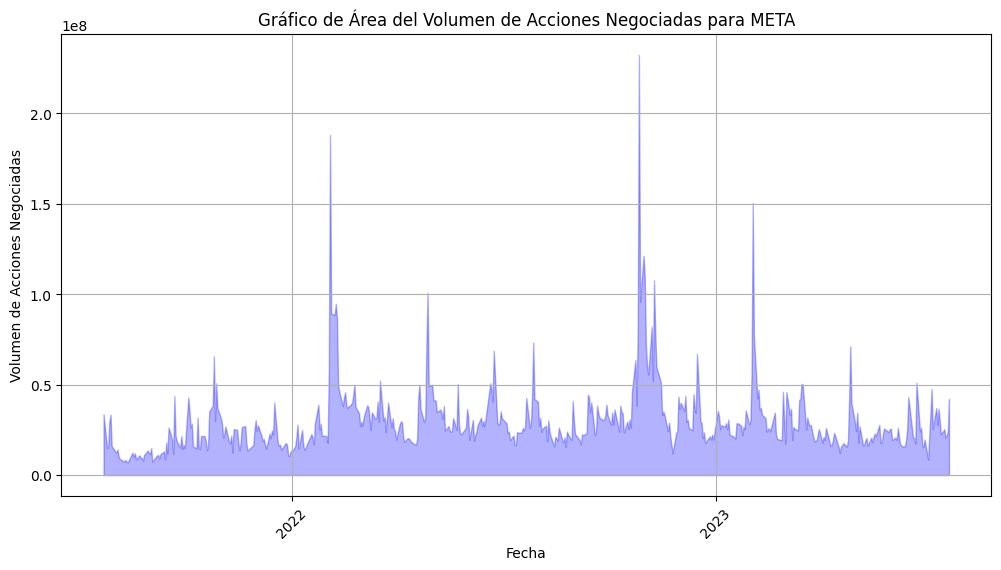

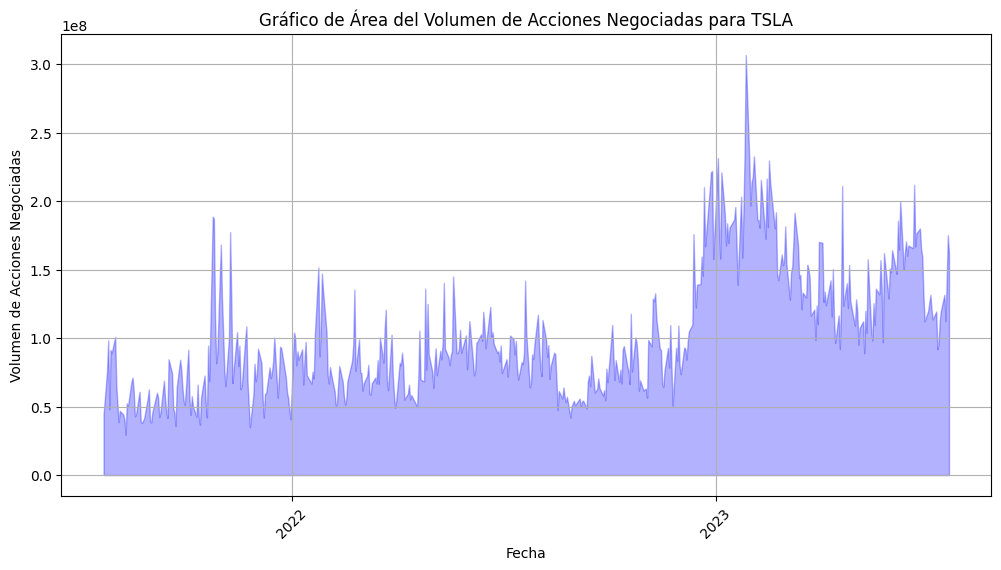

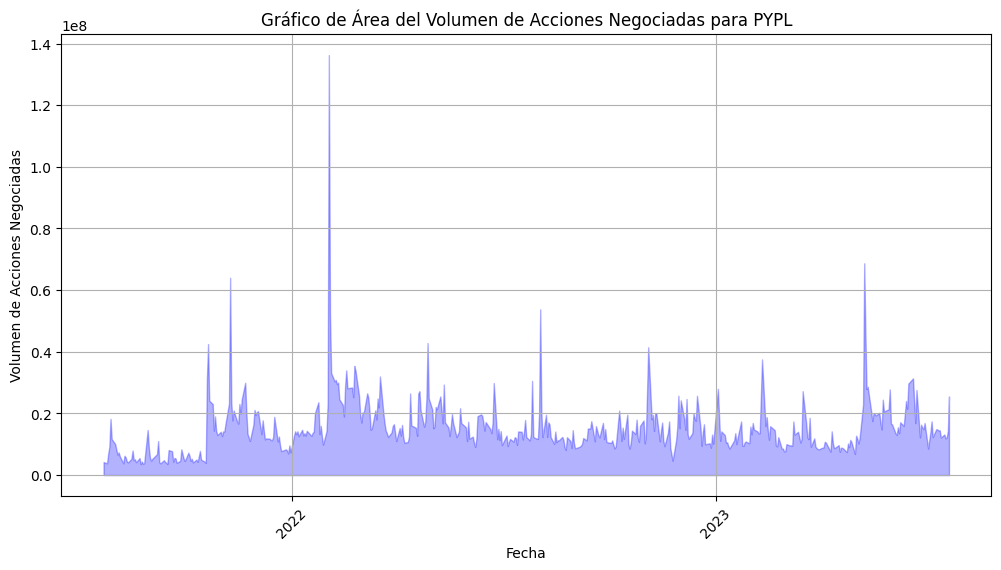

In [21]:
# Ejemplo de uso:
#empresa_a_graficar = 'AAPL'  # Puedes cambiar esto por otra empresa de la lista
for empresa in empresas:
    grafico_area_volumen(df, empresa)

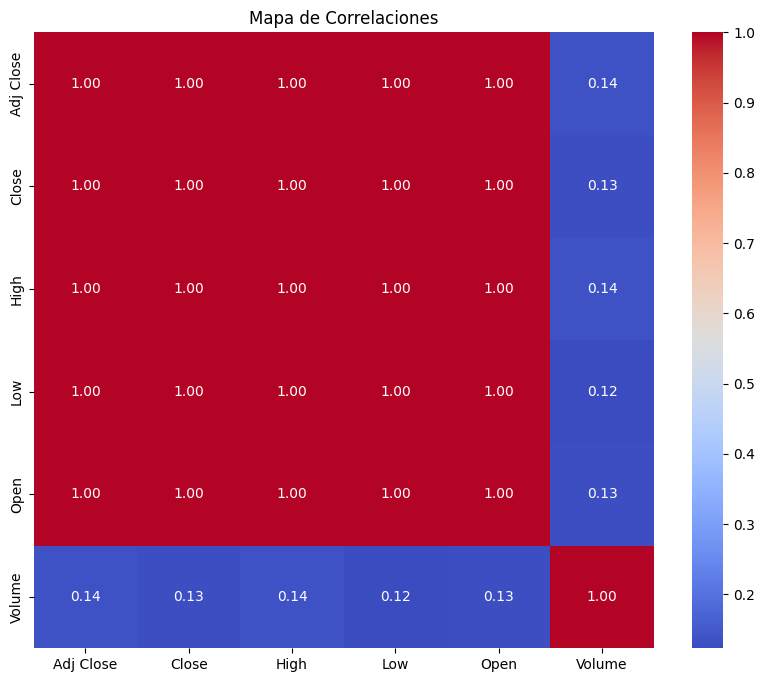

In [22]:
# Crear el mapa de correlaciones
correlation_matrix = df.corr()

# Crear el gráfico utilizando Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Correlaciones')
plt.show()

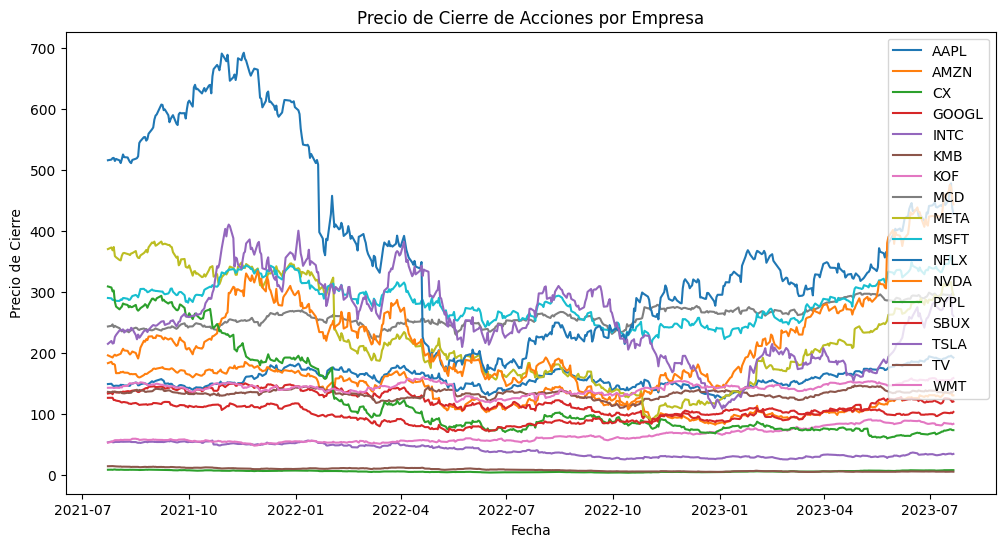

In [23]:
# Supongamos que ya tienes tu DataFrame df con la columna "Date" en formato datetime,
# la columna "Close" con los precios de cierre y la columna "Symbol" con el símbolo de la empresa

# Crear una figura y ejes para la visualización
fig, ax = plt.subplots(figsize=(12, 6))

# Segmentar los datos por empresa y crear una línea para cada una de ellas
for empresa, data in df.groupby('Symbol'):
    ax.plot(data['Date'], data['Close'], label=empresa)

# Configurar el aspecto del gráfico
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio de Cierre')
ax.set_title('Precio de Cierre de Acciones por Empresa')
ax.legend()
plt.show()

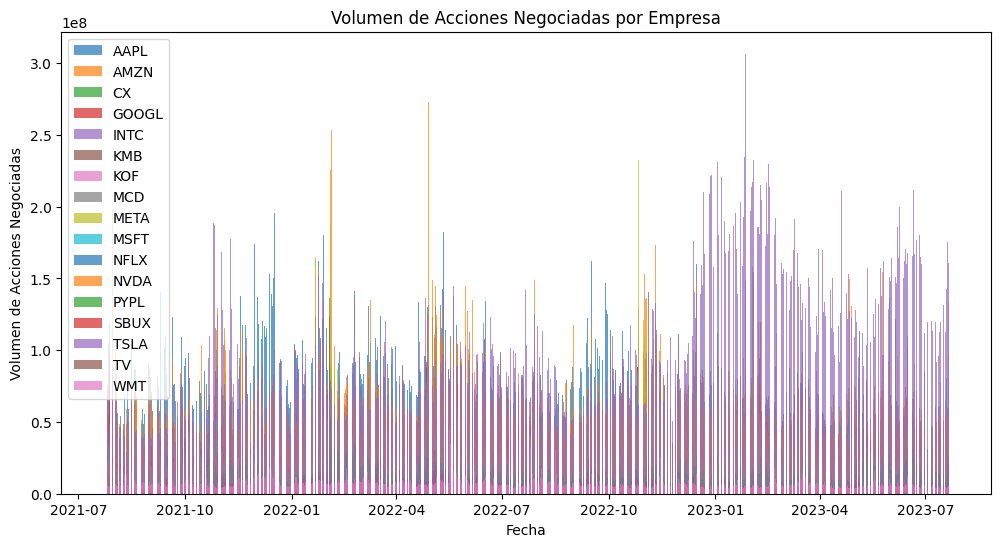

In [24]:
# Crear una figura y ejes para la visualización
fig, ax = plt.subplots(figsize=(12, 6))

# Segmentar los datos por empresa y crear un gráfico de barras para el volumen de cada una
for empresa, data in df.groupby('Symbol'):
    ax.bar(data['Date'], data['Volume'], label=empresa, alpha=0.7)

# Configurar el aspecto del gráfico
ax.set_xlabel('Fecha')
ax.set_ylabel('Volumen de Acciones Negociadas')
ax.set_title('Volumen de Acciones Negociadas por Empresa')
ax.legend()
plt.show()

In [25]:
#Gráfico de velas (Candlestick chart) para el comportamiento de cada empresa:

#Estos son solo algunos ejemplos de cómo segmentar las visualizaciones por empresa. 
#Puedes adaptar estos códigos según tus necesidades y preferencias de visualización. 
#Con estas visualizaciones segmentadas, podrás analizar 
#Y comparar fácilmente el comportamiento de las acciones de cada empresa a lo largo del tiempo.

# Segmentar los datos por empresa y crear un gráfico de velas para cada una
fig = go.Figure()

for empresa, data in df.groupby('Symbol'):
    candlestick = go.Candlestick(x=data['Date'],
                                 open=data['Open'],
                                 high=data['High'],
                                 low=data['Low'],
                                 close=data['Close'],
                                 name=empresa)
    fig.add_trace(candlestick)

# Configurar el aspecto del gráfico
fig.update_layout(title='Gráfico de Velas - Comportamiento de Acciones por Empresa',
                  xaxis_title='Fecha',
                  yaxis_title='Precio',
                  xaxis_rangeslider_visible=False)
fig.show()

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next 

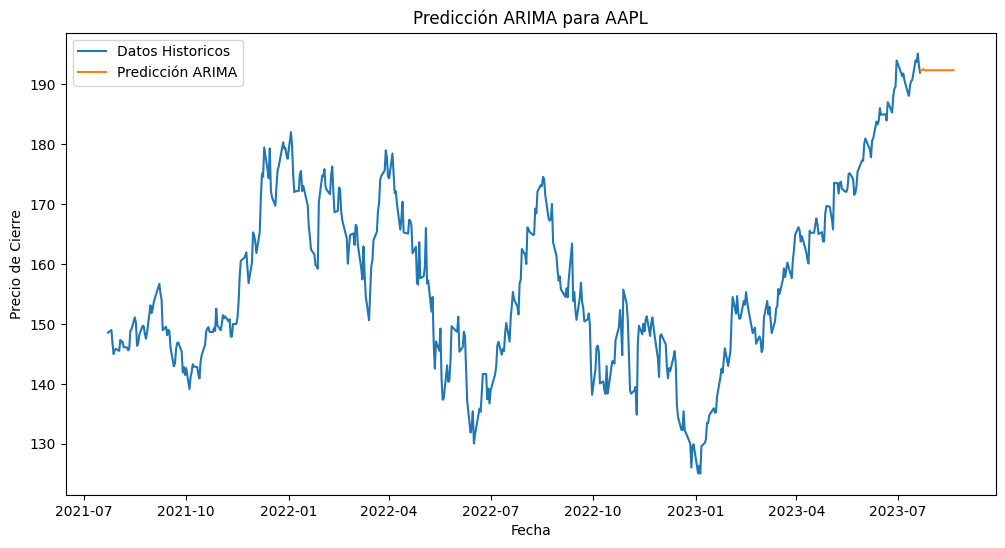

Fecha  Prediccion_ARIMA
502 2023-07-22        192.310096
503 2023-07-23        192.368769
504 2023-07-24        192.510737
505 2023-07-25        192.404509
506 2023-07-26        192.302255
507 2023-07-27        192.332100
508 2023-07-28        192.340880
509 2023-07-29        192.352864
510 2023-07-30        192.347703
511 2023-07-31        192.338906
512 2023-08-01        192.340920
513 2023-08-02        192.341877
514 2023-08-03        192.342810
515 2023-08-04        192.342626
516 2023-08-05        192.341889
517 2023-08-06        192.342000
518 2023-08-07        192.342094
519 2023-08-08        192.342164
520 2023-08-09        192.342166
521 2023-08-10        192.342106
522 2023-08-11        192.342110
523 2023-08-12        192.342118
524 2023-08-13        192.342124
525 2023-08-14        192.342125
526 2023-08-15        192.342120
527 2023-08-16        192.342120
528 2023-08-17        192.342121
529 2023-08-18        192.342121
530 2023-08-19        192.342121
531 2023-08-20        192.342121

In [26]:

def arima_prediction(data, empresa):
    # Asumimos que tienes el DataFrame df con las columnas 'Date', 'Close' y 'Symbol'

    # Filtrar los datos para la empresa seleccionada
    data_empresa = data[data['Symbol'] == empresa]

    # Convertir la columna 'Date' en el índice del DataFrame
    data_empresa.set_index('Date', inplace=True)

    # Crear el modelo ARIMA
    model = ARIMA(data_empresa['Close'], order=(5, 1, 0))
    model_fit = model.fit()

    # Realizar la predicción para 30 días en el futuro
    forecast = model_fit.forecast(steps=30)

    # Crear un DataFrame con las fechas y las predicciones
    future_dates = pd.date_range(start=data_empresa.index[-1], periods=31, closed='right')
    forecast_df = pd.DataFrame({'Fecha': future_dates, 'Prediccion_ARIMA': forecast})

    # Visualizar los resultados
    plt.figure(figsize=(12, 6))
    plt.plot(data_empresa.index, data_empresa['Close'], label='Datos Historicos')
    plt.plot(forecast_df['Fecha'], forecast_df['Prediccion_ARIMA'], label='Predicción ARIMA')
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre')
    plt.title(f'Predicción ARIMA para {empresa}')
    plt.legend()
    plt.show()

    return forecast_df

# Ejemplo de uso
# Para obtener la predicción para la empresa 'AAPL':
arima_prediction(df, 'AAPL')

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55604D+00    |proj g|=  1.03857D-01
 This problem is unconstrained.

At iterate    5    f=  2.46103D+00    |proj g|=  2.30643D-02

At iterate   10    f=  2.44880D+00    |proj g|=  7.35115D-03

At iterate   15    f=  2.44811D+00    |proj g|=  4.84919D-04

At iterate   20    f=  2.44805D+00    |proj g|=  2.60348D-04

At iterate   25    f=  2.44804D+00    |proj g|=  5.2

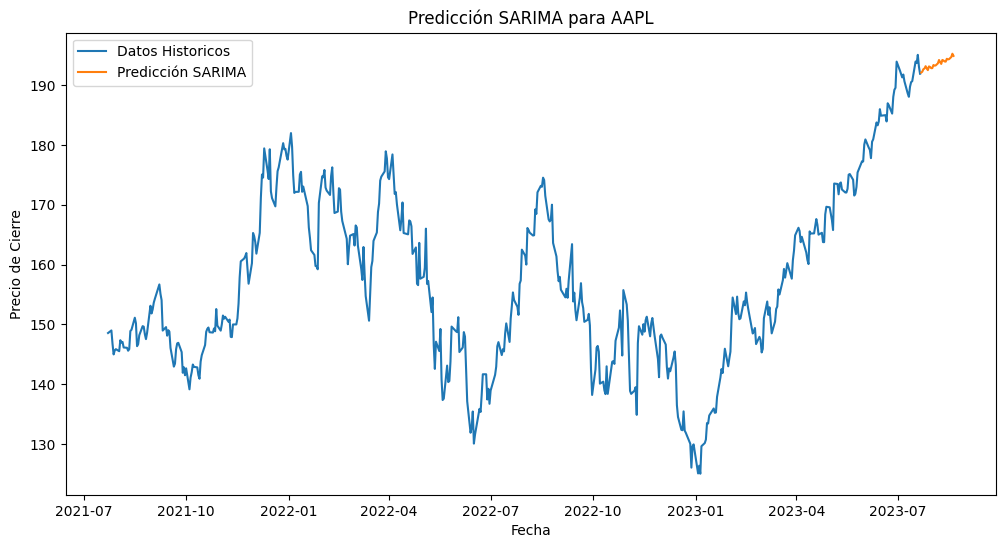

Fecha  Prediccion_SARIMA
502 2023-07-22         192.127606
503 2023-07-23         192.278727
504 2023-07-24         192.699803
505 2023-07-25         192.814468
506 2023-07-26         193.203636
507 2023-07-27         192.832857
508 2023-07-28         192.544704
509 2023-07-29         193.167191
510 2023-07-30         193.069598
511 2023-07-31         192.869317
512 2023-08-01         192.881612
513 2023-08-02         193.398432
514 2023-08-03         193.295956
515 2023-08-04         193.327613
516 2023-08-05         193.501000
517 2023-08-06         193.680116
518 2023-08-07         194.237430
519 2023-08-08         193.873507
520 2023-08-09         193.584672
521 2023-08-10         194.250077
522 2023-08-11         194.150007
523 2023-08-12         193.996077
524 2023-08-13         193.963493
525 2023-08-14         194.441301
526 2023-08-15         194.343981
527 2023-08-16         194.378040
528 2023-08-17         194.557839
529 2023-08-18         194.735551
530 2023-08-19         195.289041
531 2023-08-20         194.924868

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarima_prediction(data, empresa):
    # Asumimos que tienes el DataFrame df con las columnas 'Date', 'Close' y 'Symbol'

    # Filtrar los datos para la empresa seleccionada
    data_empresa = data[data['Symbol'] == empresa]

    # Convertir la columna 'Date' en el índice del DataFrame
    data_empresa.set_index('Date', inplace=True)

    # Crear el modelo SARIMA
    model = SARIMAX(data_empresa['Close'], order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit()

    # Realizar la predicción para 30 días en el futuro
    forecast = model_fit.forecast(steps=30)

    # Crear un DataFrame con las fechas y las predicciones
    future_dates = pd.date_range(start=data_empresa.index[-1], periods=31, closed='right')
    forecast_df = pd.DataFrame({'Fecha': future_dates, 'Prediccion_SARIMA': forecast})

    # Visualizar los resultados
    plt.figure(figsize=(12, 6))
    plt.plot(data_empresa.index, data_empresa['Close'], label='Datos Historicos')
    plt.plot(forecast_df['Fecha'], forecast_df['Prediccion_SARIMA'], label='Predicción SARIMA')
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre')
    plt.title(f'Predicción SARIMA para {empresa}')
    plt.legend()
    plt.show()

    return forecast_df

# Ejemplo de uso
# Para obtener la predicción para la empresa 'AAPL':
sarima_prediction(df, 'AAPL')

In [28]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def lstm_prediction(data, empresa):
    # Asumimos que tienes el DataFrame df con las columnas 'Date', 'Close' y 'Symbol'

    # Filtrar los datos para la empresa seleccionada
    data_empresa = data[data['Symbol'] == empresa]

    # Convertir la columna 'Date' en el índice del DataFrame
    data_empresa.set_index('Date', inplace=True)

    # Normalizar los datos entre 0 y 1
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data_empresa[['Close']])

    # Crear secuencias de entrenamiento y prueba
    sequence_length = 30
    X_train, y_train = [], []
    for i in range(sequence_length, len(scaled_data)):
        X_train.append(scaled_data[i - sequence_length:i, 0])
        y_train.append(scaled_data[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshape para el input de LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Crear y entrenar el modelo LSTM
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=16)

    # Realizar la predicción para 30 días en el futuro
    last_sequence = scaled_data[-sequence_length:]
    forecast = []
    for _ in range(30):
        last_sequence = last_sequence.reshape(1, sequence_length, 1)
        prediction = model.predict(last_sequence)
        forecast.append(prediction[0, 0])
        # Por esta línea:
        last_sequence = np.append(last_sequence[:, 1:, :], [[[prediction[0, 0]]]], axis=1)

    # Escalar las predicciones de vuelta a los precios originales
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

    # Crear un DataFrame con las fechas y las predicciones
    future_dates = pd.date_range(start=data_empresa.index[-1], periods=31, closed='right')
    forecast_df = pd.DataFrame({'Fecha': future_dates, 'Prediccion_LSTM': forecast.flatten()})

    # Visualizar los resultados
    plt.figure(figsize=(12, 6))
    plt.plot(data_empresa.index, data_empresa['Close'], label='Datos Historicos')
    plt.plot(forecast_df['Fecha'], forecast_df['Prediccion_LSTM'], label='Predicción LSTM')
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre')
    plt.title(f'Predicción LSTM para {empresa}')
    plt.legend()
    plt.show()

    return forecast_df



2023-07-22 20:39:36.178625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-22 20:39:36.178664: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-22 20:39:36.178692: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-f6fb7b39-efbc-4a41-ae69-b9e76fee5664): /proc/driver/nvidia/version does not exist
2023-07-22 20:39:36.178991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Epoch 1/100
30/30 [==============================] - 5s 69ms/step - loss: 0.

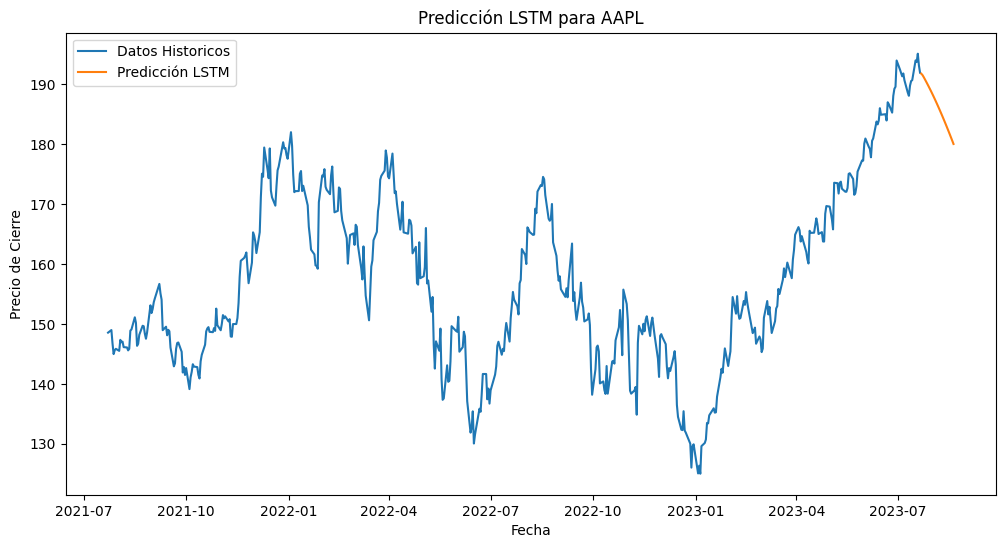

Fecha  Prediccion_LSTM
0  2023-07-22       191.777603
1  2023-07-23       191.594940
2  2023-07-24       191.293091
3  2023-07-25       190.954605
4  2023-07-26       190.607849
5  2023-07-27       190.256348
6  2023-07-28       189.899231
7  2023-07-29       189.535934
8  2023-07-30       189.166153
9  2023-07-31       188.789902
10 2023-08-01       188.407043
11 2023-08-02       188.017700
12 2023-08-03       187.622101
13 2023-08-04       187.220306
14 2023-08-05       186.812408
15 2023-08-06       186.398636
16 2023-08-07       185.978943
17 2023-08-08       185.553543
18 2023-08-09       185.122559
19 2023-08-10       184.686142
20 2023-08-11       184.244339
21 2023-08-12       183.797302
22 2023-08-13       183.345169
23 2023-08-14       182.887909
24 2023-08-15       182.425598
25 2023-08-16       181.958282
26 2023-08-17       181.485977
27 2023-08-18       181.008820
28 2023-08-19       180.526840
29 2023-08-20       180.040222

In [29]:
# Ejemplo de uso
# Para obtener la predicción para la empresa 'AAPL':
lstm_prediction(df, 'AAPL')

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next 

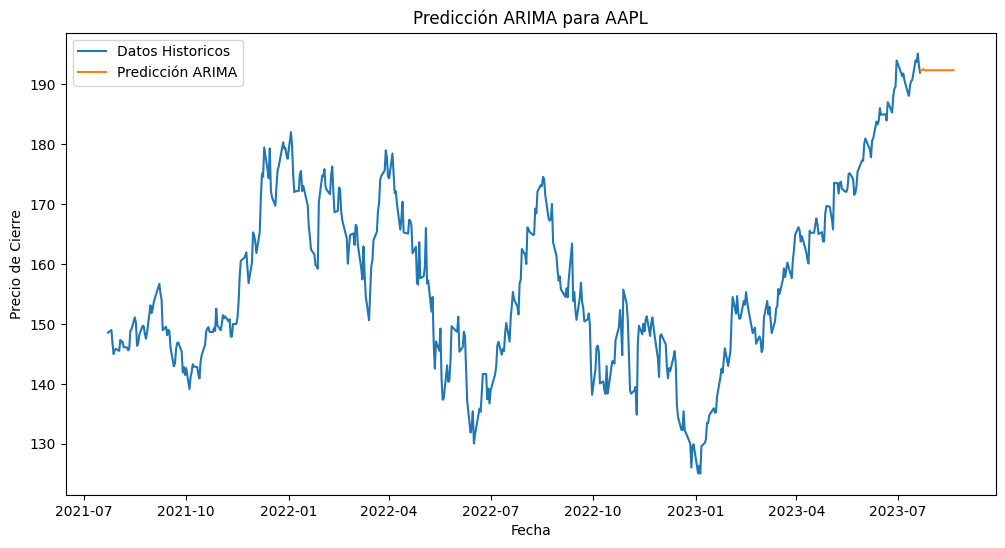

Fecha  Prediccion_ARIMA
502 2023-07-22        192.310096
503 2023-07-23        192.368769
504 2023-07-24        192.510737
505 2023-07-25        192.404509
506 2023-07-26        192.302255
507 2023-07-27        192.332100
508 2023-07-28        192.340880
509 2023-07-29        192.352864
510 2023-07-30        192.347703
511 2023-07-31        192.338906
512 2023-08-01        192.340920
513 2023-08-02        192.341877
514 2023-08-03        192.342810
515 2023-08-04        192.342626
516 2023-08-05        192.341889
517 2023-08-06        192.342000
518 2023-08-07        192.342094
519 2023-08-08        192.342164
520 2023-08-09        192.342166
521 2023-08-10        192.342106
522 2023-08-11        192.342110
523 2023-08-12        192.342118
524 2023-08-13        192.342124
525 2023-08-14        192.342125
526 2023-08-15        192.342120
527 2023-08-16        192.342120
528 2023-08-17        192.342121
529 2023-08-18        192.342121
530 2023-08-19        192.342121
531 2023-08-20        192.342121

In [30]:
def arima_prediction(data, empresa):
    # Asumimos que tienes el DataFrame df con las columnas 'Date', 'Close' y 'Symbol'

    # Filtrar los datos para la empresa seleccionada
    data_empresa = data[data['Symbol'] == empresa]

    # Convertir la columna 'Date' en el índice del DataFrame
    data_empresa.set_index('Date', inplace=True)

    # Crear el modelo ARIMA
    model = ARIMA(data_empresa['Close'], order=(5, 1, 0))
    model_fit = model.fit()

    # Realizar la predicción para 30 días en el futuro
    forecast = model_fit.forecast(steps=30)

    # Crear un DataFrame con las fechas y las predicciones
    future_dates = pd.date_range(start=data_empresa.index[-1] + pd.Timedelta(days=1), periods=30)
    forecast_df = pd.DataFrame({'Fecha': future_dates, 'Prediccion_ARIMA': forecast})

    # Visualizar los resultados
    plt.figure(figsize=(12, 6))
    plt.plot(data_empresa.index, data_empresa['Close'], label='Datos Historicos')
    plt.plot(forecast_df['Fecha'], forecast_df['Prediccion_ARIMA'], label='Predicción ARIMA')
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre')
    plt.title(f'Predicción ARIMA para {empresa}')
    plt.legend()
    plt.show()

    return forecast_df

# Ejemplo de uso
# Para obtener la predicción para la empresa 'AAPL':
arima_prediction(df, 'AAPL')

Epoch 1/100
30/30 [==============================] - 5s 68ms/step - loss: 0.0555
Epoch 2/100
30/30 [==============================] - 2s 68ms/step - loss: 0.0105
Epoch 3/100
30/30 [==============================] - 2s 72ms/step - loss: 0.0077
Epoch 4/100
30/30 [==============================] - 2s 67ms/step - loss: 0.0065
Epoch 5/100
30/30 [==============================] - 2s 66ms/step - loss: 0.0059
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.0056
Epoch 7/100
30/30 [==============================] - 2s 68ms/step - loss: 0.0052
Epoch 8/100
30/30 [==============================] - 2s 69ms/step - loss: 0.0047
Epoch 9/100
30/30 [==============================] - 2s 66ms/step - loss: 0.0044
Epoch 10/100
30/30 [==============================] - 2s 68ms/step - loss: 0.0043
Epoch 11/100
30/30 [==============================] - 2s 69ms/step - loss: 0.0041
Epoch 12/100
30/30 [==============================] - 2s 65ms/step - loss: 0.0040
Epoch 13/100
30/30 [=====

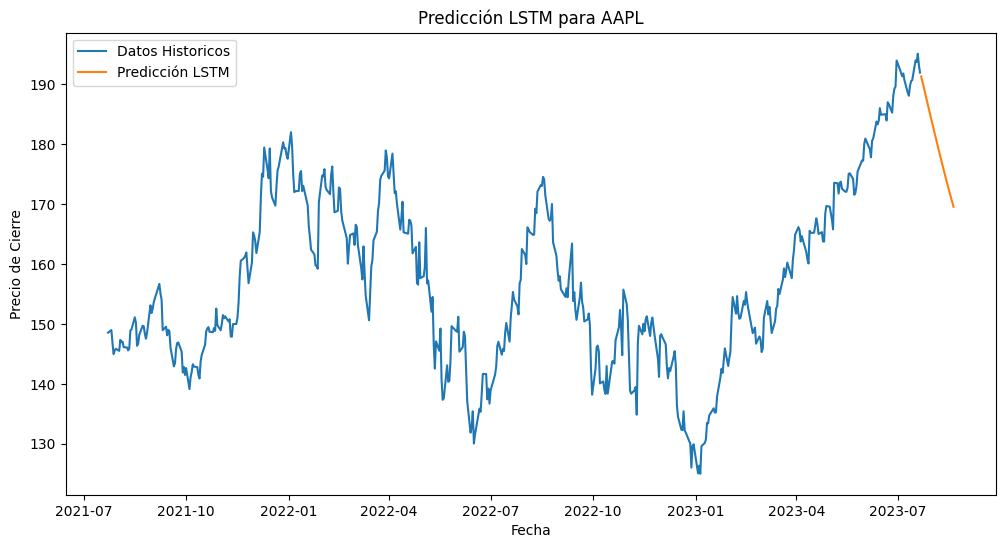

Fecha  Prediccion_LSTM
0  2023-07-22       191.313278
1  2023-07-23       190.563110
2  2023-07-24       189.777512
3  2023-07-25       188.981293
4  2023-07-26       188.181915
5  2023-07-27       187.383606
6  2023-07-28       186.588837
7  2023-07-29       185.798477
8  2023-07-30       185.012497
9  2023-07-31       184.230515
10 2023-08-01       183.452179
11 2023-08-02       182.677017
12 2023-08-03       181.904816
13 2023-08-04       181.135696
14 2023-08-05       180.369827
15 2023-08-06       179.607620
16 2023-08-07       178.849594
17 2023-08-08       178.096130
18 2023-08-09       177.347702
19 2023-08-10       176.604813
20 2023-08-11       175.867859
21 2023-08-12       175.137238
22 2023-08-13       174.413376
23 2023-08-14       173.696747
24 2023-08-15       172.987717
25 2023-08-16       172.286606
26 2023-08-17       171.593781
27 2023-08-18       170.909500
28 2023-08-19       170.233978
29 2023-08-20       169.567307

In [31]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def lstm_prediction(data, empresa):
    # Asumimos que tienes el DataFrame df con las columnas 'Date', 'Close' y 'Symbol'

    # Filtrar los datos para la empresa seleccionada
    data_empresa = data[data['Symbol'] == empresa]

    # Convertir la columna 'Date' en el índice del DataFrame
    data_empresa.set_index('Date', inplace=True)

    # Normalizar los datos entre 0 y 1
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data_empresa[['Close']])

    # Crear secuencias de entrenamiento y prueba
    sequence_length = 30
    X_train, y_train = [], []
    for i in range(sequence_length, len(scaled_data)):
        X_train.append(scaled_data[i - sequence_length:i, 0])
        y_train.append(scaled_data[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshape para el input de LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Crear y entrenar el modelo LSTM
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=16)

    # Realizar la predicción para 30 días en el futuro
    last_sequence = scaled_data[-sequence_length:]
    forecast = []
    for _ in range(30):
        last_sequence = last_sequence.reshape(1, sequence_length, 1)
        prediction = model.predict(last_sequence)
        forecast.append(prediction[0, 0])
        last_sequence = np.append(last_sequence[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

    # Escalar las predicciones de vuelta a los precios originales
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

    # Crear un DataFrame con las fechas y las predicciones
    future_dates = pd.date_range(start=data_empresa.index[-1], periods=31, closed='right')
    forecast_df = pd.DataFrame({'Fecha': future_dates, 'Prediccion_LSTM': forecast.flatten()})

    # Visualizar los resultados
    plt.figure(figsize=(12, 6))
    plt.plot(data_empresa.index, data_empresa['Close'], label='Datos Historicos')
    plt.plot(forecast_df['Fecha'], forecast_df['Prediccion_LSTM'], label='Predicción LSTM')
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre')
    plt.title(f'Predicción LSTM para {empresa}')
    plt.legend()
    plt.show()

    return forecast_df

# Ejemplo de uso
# Para obtener la predicción para la empresa 'AAPL':
lstm_prediction(df, 'AAPL')


/tmp/ipykernel_101/131221880.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Error cuadrático medio para AAPL: 222.30860156655172


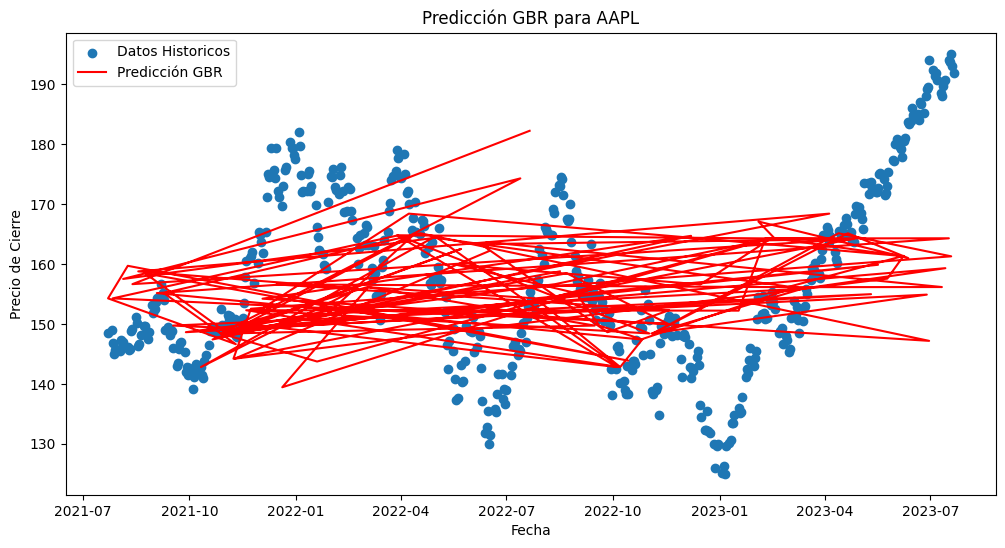

array([158.78249842, 148.42457912, 149.73952291, 156.14985655,
       139.44633309, 155.15684913, 164.27916343, 143.74212825,
       148.42457912, 174.29686079, 157.5199922 , 164.43064131,
       142.82039238, 152.29664563, 152.22996361, 164.27916343,
       164.30396036, 155.15684913, 147.42032826, 156.14985655,
       156.16931081, 156.16931081, 163.67705185, 162.16071834,
       144.21566581, 157.57052656, 161.370521  , 156.14985655,
       156.61271929, 152.29664563, 148.63495683, 163.33513499,
       164.15901115, 164.80675678, 154.27855971, 150.05698768,
       158.45693072, 148.42457912, 162.52938059, 147.42032826,
       164.71087953, 154.22549529, 147.18963514, 165.14265153,
       155.15684913, 146.63581212, 154.27855971, 159.71261267,
       143.89199591, 158.45693072, 148.42457912, 164.8607368 ,
       151.70554261, 155.89258478, 164.43064131, 142.82039238,
       155.91049596, 158.78249842, 168.41683966, 149.24169705,
       159.3168378 , 155.89258478, 148.42457912, 154.90

In [32]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def gbr_prediction(data, empresa):
    # Asumimos que tienes el DataFrame df con las columnas 'Date', 'Close' y 'Symbol'

    # Filtrar los datos para la empresa seleccionada
    data_empresa = data[data['Symbol'] == empresa]

    # Convertir la columna 'Date' en el índice del DataFrame
    data_empresa.set_index('Date', inplace=True)

    # Crear una nueva columna 'DiaDelAño' para representar la fecha como un valor numérico
    data_empresa['DiaDelAño'] = data_empresa.index.dayofyear

    # Dividir los datos en entrenamiento y prueba
    X = data_empresa[['DiaDelAño']]
    y = data_empresa['Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crear y entrenar el modelo Gradient Boosting Regressor
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    # Realizar la predicción para los datos de prueba
    y_pred = model.predict(X_test)

    # Calcular el error cuadrático medio
    mse = mean_squared_error(y_test, y_pred)
    print(f"Error cuadrático medio para {empresa}: {mse}")

    # Visualizar los resultados
    plt.figure(figsize=(12, 6))
    plt.scatter(data_empresa.index, data_empresa['Close'], label='Datos Historicos')
    plt.plot(X_test.index, y_pred, color='r', label='Predicción GBR')
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre')
    plt.title(f'Predicción GBR para {empresa}')
    plt.legend()
    plt.show()

    return y_pred

# Ejemplo de uso
# Para obtener la predicción para la empresa 'AAPL':
gbr_prediction(df, 'AAPL')


In [33]:
df.to_csv('Datos.csv')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f6fb7b39-efbc-4a41-ae69-b9e76fee5664' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>